<a href="https://colab.research.google.com/github/nhbbobb1985/BettaFish/blob/main/%E6%8B%9F%E5%90%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 欢迎使用 Colab！

正在读取并清洗数据...

✂️ 正在裁剪当前数据...
   找到起点 (5/8): 2025-12-09 00:00:00
   ⚠️ 未找到 LQ 标记，默认使用文件末尾。
✅ 最终用于匹配的 K 线长度: 91 小时

🔍 正在扫描历史上的 101 个 LQ 时刻...


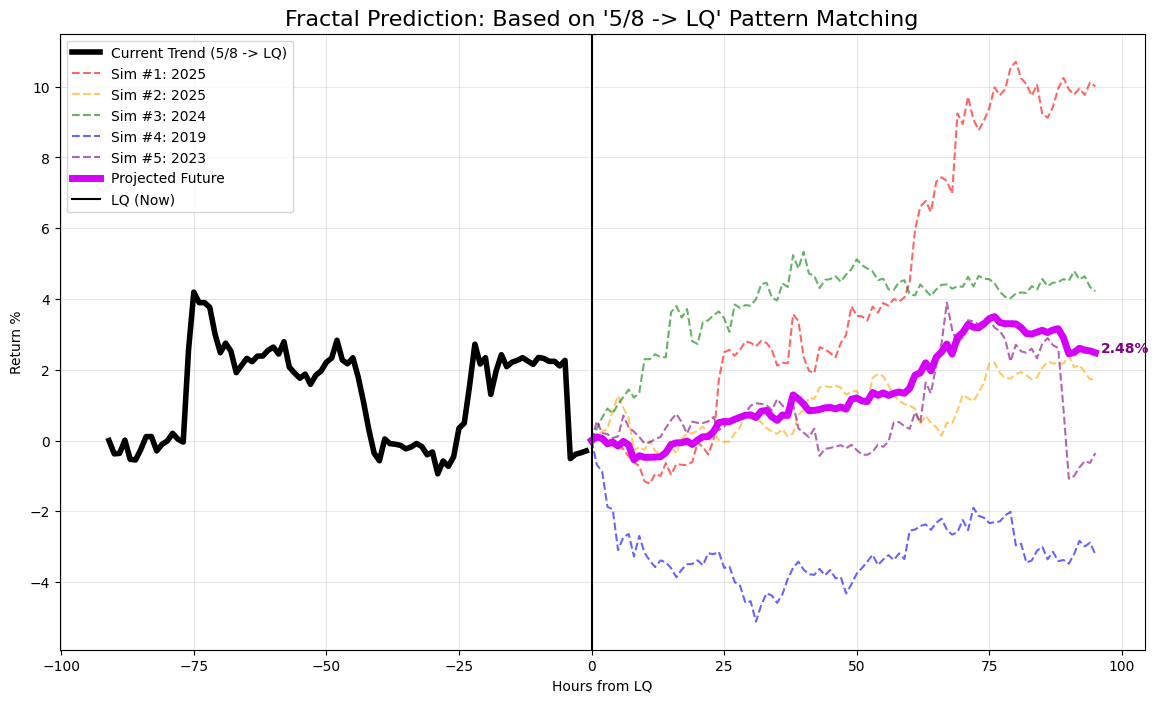


=== 🔮 剧本推演 (LQ -> 7/8) ===
基于过去 4 年中走势最像的 5 个案例：
预期平均涨幅: 2.48%
🚀 结论：虽然 5/8->LQ 可能走得纠结，但形态匹配显示 LQ 后会有加速拉升！建议持有。


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import io

# ==========================================
# 1. 文件路径设置
# ==========================================

# 历史大数据库
history_file_path = '/content/2.csv'

# 当前最近的小文件 (包含 5/8 和 LQ 标记)
current_file_path = '/content/1.csv'
# ⚠️ 请确保小文件里也要有 KeyMarker 列，并且标记了 '5/8' 和 'LQ' (或 Last Quarter)

# ==========================================
# 2. 数据加载与清洗函数
# ==========================================
def load_and_clean(path):
    try:
        df = pd.read_csv(path)
        if 'Timestamp' in df.columns:
            df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
        else:
            df['Date'] = pd.to_datetime(df['Date'])

        df = df.sort_values('Date').drop_duplicates(subset=['Date'], keep='last').reset_index(drop=True)

        # 统一标记名称
        df['KeyMarker'] = df['KeyMarker'].fillna('').astype(str).str.strip().str.upper()
        name_map = {
            'NEW MOON': 'NEW', 'FULL MOON': 'FULL',
            'FIRST QUARTER': 'FQ', '1ST QUARTER': 'FQ',
            'LAST QUARTER': 'LQ', '3RD QUARTER': 'LQ'
        }
        df['KeyMarker'] = df['KeyMarker'].replace(name_map)
        return df
    except Exception as e:
        print(f"❌ 读取错误 {path}: {e}")
        return pd.DataFrame()

print("正在读取并清洗数据...")
df_hist = load_and_clean(history_file_path)
df_curr = load_and_clean(current_file_path)

if not df_hist.empty and not df_curr.empty:

    # ==========================================
    # 3. 智能裁剪当前形态 (Auto-Crop)
    # ==========================================
    print("\n✂️ 正在裁剪当前数据...")

    # 找起点 (5/8)
    idx_start_list = df_curr[df_curr['KeyMarker'] == '5/8'].index.tolist()
    if idx_start_list:
        start_idx = idx_start_list[-1] # 取最后一个 5/8 (防止文件里有多个周期)
        print(f"   找到起点 (5/8): {df_curr.iloc[start_idx]['Date']}")
    else:
        start_idx = 0
        print("   ⚠️ 未找到 5/8 标记，默认从文件开头开始。")

    # 找终点 (LQ)
    idx_end_list = df_curr[df_curr['KeyMarker'] == 'LQ'].index.tolist()
    if idx_end_list:
        end_idx = idx_end_list[-1] # 取最后一个 LQ
        print(f"   找到终点 (LQ) : {df_curr.iloc[end_idx]['Date']}")
    else:
        end_idx = len(df_curr) - 1
        print("   ⚠️ 未找到 LQ 标记，默认使用文件末尾。")

    # 截取纯净片段
    if end_idx > start_idx:
        df_pattern = df_curr.iloc[start_idx : end_idx + 1].copy()
    else:
        print("❌ 错误：LQ 时间在 5/8 之前，或者数据顺序有误。使用全部数据。")
        df_pattern = df_curr.copy()

    print(f"✅ 最终用于匹配的 K 线长度: {len(df_pattern)} 小时")

    # ==========================================
    # 4. 形态匹配 (Pattern Matching)
    # ==========================================

    # 归一化当前形态
    p_curr = df_pattern['Close'].values
    norm_curr = (p_curr - p_curr[0]) / p_curr[0] * 100
    len_pat = len(norm_curr)

    matches = []

    # 在历史中寻找 LQ 点，倒推匹配
    hist_lq_idxs = df_hist[df_hist['KeyMarker'] == 'LQ'].index.tolist()

    print(f"\n🔍 正在扫描历史上的 {len(hist_lq_idxs)} 个 LQ 时刻...")

    for idx in hist_lq_idxs:
        # 排除最近的时间（不匹配自己）
        if df_hist.iloc[idx]['Date'] >= df_pattern.iloc[0]['Date']:
            continue

        # 历史片段的起点
        h_start = idx - len_pat + 1
        if h_start < 0: continue

        # 提取历史片段
        p_hist = df_hist.iloc[h_start : idx + 1]['Close'].values
        norm_hist = (p_hist - p_hist[0]) / p_hist[0] * 100

        # 计算相似度
        dist = euclidean(norm_curr, norm_hist)

        # 提取未来走势 (LQ -> 7/8 约 4 天 = 96小时)
        future_len = 96
        if idx + future_len >= len(df_hist): continue

        p_future = df_hist.iloc[idx : idx + future_len]['Close'].values
        norm_future = (p_future - p_future[0]) / p_future[0] * 100

        matches.append({
            'score': dist,
            'date': df_hist.iloc[idx]['Date'],
            'future_pattern': norm_future
        })

    # ==========================================
    # 5. 绘图与预测
    # ==========================================
    matches.sort(key=lambda x: x['score'])
    top_matches = matches[:5] # 取最像的前5个

    plt.figure(figsize=(14, 8))

    # 画当前 (黑色)
    x_past = range(-len_pat, 0)
    plt.plot(x_past, norm_curr, color='black', linewidth=4, label='Current Trend (5/8 -> LQ)', zorder=10)

    # 画历史预测
    future_collection = []
    colors = ['red', 'orange', 'green', 'blue', 'purple']

    for i, m in enumerate(top_matches):
        plt.plot(range(len(m['future_pattern'])), m['future_pattern'],
                 color=colors[i], linestyle='--', alpha=0.6,
                 label=f"Sim #{i+1}: {m['date'].year}")
        future_collection.append(m['future_pattern'])

    # 画平均预测
    if future_collection:
        avg_future = np.mean(future_collection, axis=0)
        plt.plot(range(len(avg_future)), avg_future, color='#D500F9', linewidth=5, label='Projected Future')

        # 标注
        final_ret = avg_future[-1]
        plt.text(len(avg_future), final_ret, f"{final_ret:.2f}%", color='purple', fontweight='bold')

    plt.axvline(x=0, color='black', label='LQ (Now)')
    plt.title(f"Fractal Prediction: Based on '5/8 -> LQ' Pattern Matching", fontsize=16)
    plt.xlabel('Hours from LQ')
    plt.ylabel('Return %')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 打印结论
    if future_collection:
        print("\n=== 🔮 剧本推演 (LQ -> 7/8) ===")
        print(f"基于过去 4 年中走势最像的 5 个案例：")
        avg_ret = np.mean(future_collection, axis=0)[-1]
        print(f"预期平均涨幅: {avg_ret:.2f}%")

        if avg_ret > 0.5:
            print("🚀 结论：虽然 5/8->LQ 可能走得纠结，但形态匹配显示 LQ 后会有加速拉升！建议持有。")
        elif avg_ret < 0:
            print("⚠️ 结论：历史相似形态显示 LQ 就是高点，后面会跌。建议立刻离场。")
        else:
            print("➡️ 结论：震荡行情，空间不大。")

else:
    print("❌ 请确保两个文件都已上传并路径正确。")

## Google Colab 已在 VS Code 中推出！
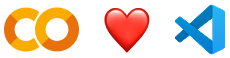

试用适用于 Visual Studio Code 的全新 <a href="https://marketplace.visualstudio.com/items?itemName=Google.colab">Google Colab 扩展程序</a>。只需点击几下即可上手使用：

*  在 VS Code 中，打开<strong>扩展程序</strong>视图，搜索“Google Colab”并安装。<em></em>
*  在本地工作区中创建或打开任意 <code>.ipynb</code> 笔记本文件，然后运行单元或点击右上角的<strong>选择内核</strong>按钮，即可打开内核选择器。<em></em>
*  点击 <strong><em>Colab</em></strong>，然后选择所需的运行时，使用您的 Google 账号登录，就大功告成了！

如需了解更多详情，请参阅<a href="https://developers.googleblog.com/google-colab-is-coming-to-vs-code">此处的公告博客</a>。


✂️ 正在裁剪当前数据...
⚠️ 警告: 未找到完整标记，使用全文件匹配。
🔍 正在扫描历史库 (共 101 个 LQ)...


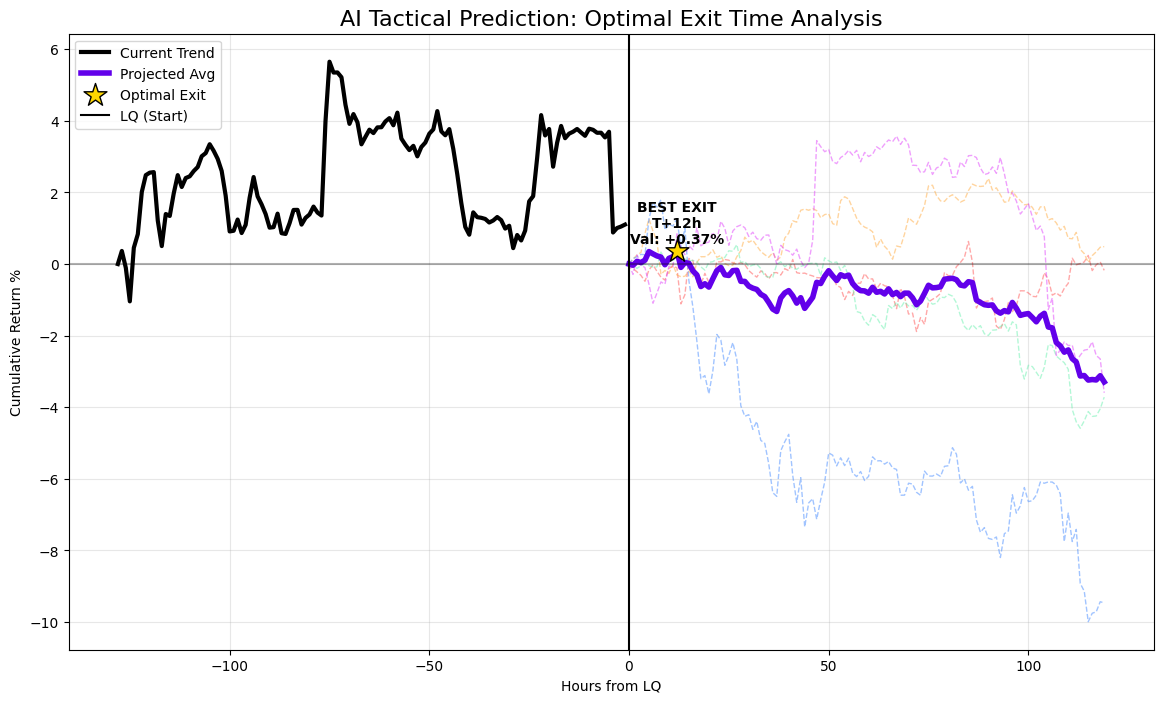


=== 🎯 最佳止盈时间推演 (AI Prediction) ===
基于当前形态最相似的 5 个历史案例：
--------------------------------------------------
⏰ 最佳卖出时间点: LQ 之后 12 小时
📅 建议卖出日期  : 2025-12-13 06:00
💰 预期最高收益  : +0.37% (相对于 LQ 价格)
🎲 该时刻胜率    : 60.0%
--------------------------------------------------
⚖️ 信号：这是一个短线波段。请定好闹钟，在 12 小时后关注盘面。


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import io

# ==========================================
# 1. 文件路径设置
# ==========================================
history_file_path = '/content/2.csv'
current_file_path = '/content/1.csv'

# ==========================================
# 2. 数据加载与清洗
# ==========================================
def load_and_clean(path):
    try:
        df = pd.read_csv(path)
        if 'Timestamp' in df.columns:
            df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
        else:
            df['Date'] = pd.to_datetime(df['Date'])

        df = df.sort_values('Date').drop_duplicates(subset=['Date'], keep='last').reset_index(drop=True)

        if 'KeyMarker' in df.columns:
            df['KeyMarker'] = df['KeyMarker'].fillna('').astype(str).str.strip().str.upper()
            name_map = {
                'NEW MOON': 'NEW', 'FULL MOON': 'FULL',
                'FIRST QUARTER': 'FQ', '1ST QUARTER': 'FQ',
                'LAST QUARTER': 'LQ', '3RD QUARTER': 'LQ'
            }
            df['KeyMarker'] = df['KeyMarker'].replace(name_map)

        return df
    except Exception as e:
        print(f"❌ 读取错误 {path}: {e}")
        return pd.DataFrame()

df_hist = load_and_clean(history_file_path)
df_curr = load_and_clean(current_file_path)

if not df_hist.empty and not df_curr.empty:

    # ==========================================
    # 3. 智能裁剪 (只取 5/8 -> LQ)
    # ==========================================
    print("\n✂️ 正在裁剪当前数据...")

    idx_start_list = df_curr[df_curr['KeyMarker'] == '5/8'].index.tolist()
    idx_end_list = df_curr[df_curr['KeyMarker'] == 'LQ'].index.tolist()

    if idx_start_list and idx_end_list:
        start_idx = idx_start_list[-1]
        end_idx = idx_end_list[-1]
        if end_idx > start_idx:
            df_pattern = df_curr.iloc[start_idx : end_idx + 1].copy()
            # 记录 LQ 的具体时间，用于推算未来时间点
            lq_time = df_curr.iloc[end_idx]['Date']
            print(f"   锁定形态: {df_pattern.iloc[0]['Date']} (5/8) -> {lq_time} (LQ)")
        else:
            print("⚠️ 警告: LQ 在 5/8 之前，使用全文件匹配。")
            df_pattern = df_curr.copy()
            lq_time = df_curr.iloc[-1]['Date']
    else:
        print("⚠️ 警告: 未找到完整标记，使用全文件匹配。")
        df_pattern = df_curr.copy()
        lq_time = df_curr.iloc[-1]['Date']

    # ==========================================
    # 4. 形态匹配 (Pattern Matching)
    # ==========================================
    p_curr = df_pattern['Close'].values
    norm_curr = (p_curr - p_curr[0]) / p_curr[0] * 100
    len_pat = len(norm_curr)

    matches = []
    hist_lq_idxs = df_hist[df_hist['KeyMarker'] == 'LQ'].index.tolist()

    print(f"🔍 正在扫描历史库 (共 {len(hist_lq_idxs)} 个 LQ)...")

    # 预测未来 120 小时 (5天，足够覆盖到 7/8)
    PREDICT_HOURS = 120

    for idx in hist_lq_idxs:
        if df_hist.iloc[idx]['Date'] >= df_pattern.iloc[0]['Date']: continue

        h_start = idx - len_pat + 1
        if h_start < 0: continue

        p_hist = df_hist.iloc[h_start : idx + 1]['Close'].values
        norm_hist = (p_hist - p_hist[0]) / p_hist[0] * 100

        dist = euclidean(norm_curr, norm_hist)

        # 提取未来
        if idx + PREDICT_HOURS >= len(df_hist): continue

        p_future = df_hist.iloc[idx : idx + PREDICT_HOURS]['Close'].values
        norm_future = (p_future - p_future[0]) / p_future[0] * 100

        matches.append({
            'score': dist,
            'date': df_hist.iloc[idx]['Date'],
            'future_pattern': norm_future
        })

    # ==========================================
    # 5. 寻找最佳卖点 (Optimal Exit)
    # ==========================================
    matches.sort(key=lambda x: x['score'])
    top_matches = matches[:5]

    future_collection = [m['future_pattern'] for m in top_matches]

    if future_collection:
        # 计算平均走势
        avg_future = np.mean(future_collection, axis=0)

        # ★★★ 核心计算：寻找最高点 ★★★
        best_hour_idx = np.argmax(avg_future)
        max_profit = avg_future[best_hour_idx]

        # 计算那个时刻的胜率 (多少个样本在那个时刻是盈利的)
        win_count_at_peak = sum([1 for seq in future_collection if seq[best_hour_idx] > 0])
        win_rate_at_peak = (win_count_at_peak / 5) * 100

        # 推算具体日期时间
        best_exit_time = lq_time + pd.Timedelta(hours=int(best_hour_idx))

        # ==========================================
        # 6. 绘图
        # ==========================================
        plt.figure(figsize=(14, 8))

        # 画过去
        x_past = range(-len_pat, 0)
        plt.plot(x_past, norm_curr, color='black', linewidth=3, label='Current Trend', zorder=10)

        # 画历史预测线
        colors = ['#FF5252', '#FFAB40', '#69F0AE', '#448AFF', '#E040FB']
        for i, m in enumerate(top_matches):
            plt.plot(range(len(m['future_pattern'])), m['future_pattern'],
                     color=colors[i], linestyle='--', alpha=0.5, linewidth=1)

        # 画平均线
        plt.plot(range(len(avg_future)), avg_future, color='#6200EA', linewidth=4, label='Projected Avg')

        # ★ 标记最佳卖点 ★
        plt.scatter(best_hour_idx, max_profit, color='gold', s=300, marker='*', zorder=20, edgecolors='black', label='Optimal Exit')

        # 标注文字
        label_text = f"BEST EXIT\nT+{best_hour_idx}h\nVal: +{max_profit:.2f}%"
        plt.text(best_hour_idx, max_profit + 0.2, label_text, ha='center', color='black', fontweight='bold')

        plt.axvline(x=0, color='black', linestyle='-', label='LQ (Start)')
        plt.axhline(0, color='black', alpha=0.3)

        plt.title(f"AI Tactical Prediction: Optimal Exit Time Analysis", fontsize=16)
        plt.xlabel('Hours from LQ')
        plt.ylabel('Cumulative Return %')
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.show()

        # ==========================================
        # 7. 最终战术报告
        # ==========================================
        print("\n=== 🎯 最佳止盈时间推演 (AI Prediction) ===")
        print(f"基于当前形态最相似的 5 个历史案例：")
        print("-" * 50)
        print(f"⏰ 最佳卖出时间点: LQ 之后 {best_hour_idx} 小时")
        print(f"📅 建议卖出日期  : {best_exit_time.strftime('%Y-%m-%d %H:%M')}")
        print(f"💰 预期最高收益  : +{max_profit:.2f}% (相对于 LQ 价格)")
        print(f"🎲 该时刻胜率    : {win_rate_at_peak}%")
        print("-" * 50)

        # 简单的策略建议
        if best_hour_idx < 12:
            print("⚠️ 警告：预测最高点就在眼前（12小时内）。建议立刻止盈或分批卖出，不要贪！")
        elif best_hour_idx > 72:
            print("🚀 信号：预测高点在 3天以后（接近 7/8）。耐心持仓，不要轻易下车。")
        else:
            print(f"⚖️ 信号：这是一个短线波段。请定好闹钟，在 {best_hour_idx} 小时后关注盘面。")

    else:
        print("❌ 未找到匹配的历史形态。")

else:
    print("❌ 请确保文件上传正确。")

## 🎁 美国境内的大学生可免费使用 Gemini 和 Colab 的 Pro 方案 🎓

获享我们最准确的 Gemini 3 Pro 模型的更多访问权限，以便开展高级编程工作、复杂研究和创新型项目，而且有 Colab 面向数据科学和机器学习的专用高性能计算资源做后盾。

前往 <a href="https://gemini.google/students?utm_source=colab&amp;utm_medium=banner&amp;utm_campaign=students_xpa_us-colab-banner">gemini.google/students</a>，获取 Gemini 免费优惠。  
前往 <a href="https://colab.research.google.com/signup">colab.research.google.com/signup</a>，获取 Colab 免费优惠。  
需遵守相关条款。

## 无需 API 密钥，即可通过 Google-Colab-AI 使用热门 AI 模型
所有用户都可以通过 <code>google-colab-ai</code> Python 库使用最热门的 LLM，而付费用户可以使用更多模型。如需了解详情，请参阅 <a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Getting_started_with_google_colab_ai.ipynb">Google Colab AI 使用入门</a>。



In [ ]:
from google.colab import ai
response = ai.generate_text("What is the capital of France?")
print(response)

## 探索 Gemini API
通过 Gemini API，您可以使用 Google DeepMind 创建的 Gemini 模型。Gemini 模型从一开始就具有多模态特性，使您能够跨文本、图片、代码和音频无缝推理。

**如何开始使用？**
*  前往 <a href="https://aistudio.google.com/">Google AI Studio</a>，然后使用 Google 账号登录。
*  <a href="https://aistudio.google.com/app/apikey">创建 API 密钥</a>。
* 查看 <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started.ipynb">Python</a> 快速入门，或使用 <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/rest/Prompting_REST.ipynb">curl</a> 调用 REST API。

**探索 Gemini 的高级功能**
*  使用 Gemini <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Image-out.ipynb">多模态输出</a>，以迭代方式混合文本和图片内容。
*  探索 <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started_LiveAPI.ipynb">Multimodal Live API</a>（点击<a href="https://aistudio.google.com/live">此处</a>可查看演示）。
*  了解如何使用 Gemini <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Spatial_understanding.ipynb&quot;">分析图片并检测照片中的内容</a>（额外福利：还有 <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Spatial_understanding_3d.ipynb">3D 版</a>！）。
*  释放 <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started_thinking.ipynb">Gemini 思考模型</a>的强大力量，利用其内在思维执行复杂任务。
      
**探索复杂的使用场景**
*  使用 <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Search_grounding_for_research_report.ipynb">Gemini 建立依据功能</a>，根据模型在网络上找到的内容，创建有关公司的报告。
*  以结构化方式从 PDF 中提取<a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Pdf_structured_outputs_on_invoices_and_forms.ipynb">账单和表单数据</a>。
*  使用 Gemini 大型上下文窗口和 Imagen，<a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Book_illustration.ipynb">根据整本书制作插图</a>。

如需了解详情，请查看 <a href="https://github.com/google-gemini/cookbook">Gemini cookbook</a> 或访问 <a href="https://ai.google.dev/docs/">Gemini API 文档</a>。


Colab 现在具备由 <a href="https://gemini.google.com">Gemini</a> 提供支持的 AI 功能。无论您是 Python 新手还是资深用户，都可以观看下方的视频，了解如何使用这些功能。

<center>
  <a href="https://www.youtube.com/watch?v=V7RXyqFUR98" target="_blank">
  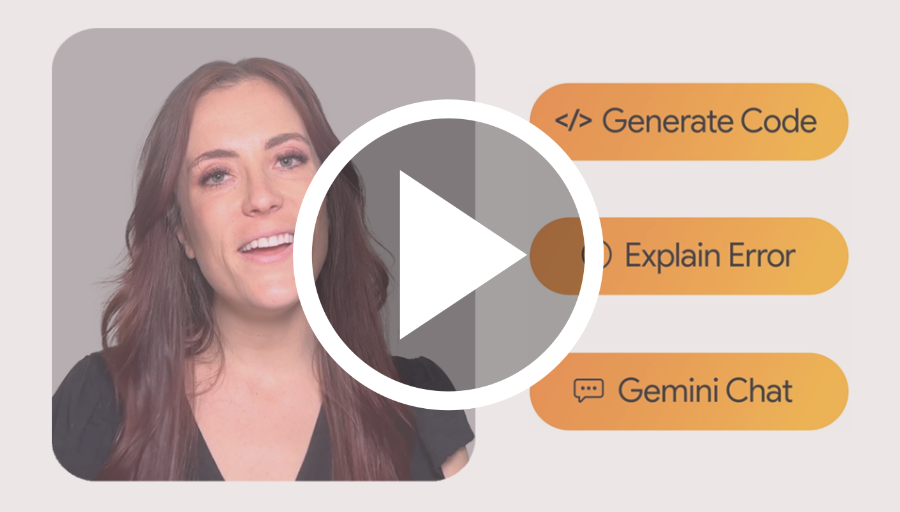
  </a>
</center>

<div class="markdown-google-sans">
  <h2>什么是 Colab？</h2>
</div>

借助 Colaboratory（简称 Colab），您可在浏览器中编写和执行 Python 代码，并且：
- 无需任何配置
- 免费使用 GPU
- 轻松共享

无论您是一名<strong>学生</strong>、<strong>数据科学家</strong>还是 <strong>AI 研究员</strong>，Colab 都能够帮助您更轻松地完成工作。您可以观看 <a href="https://www.youtube.com/watch?v=inN8seMm7UI">Introduction to Colab</a>（Colab 简介）或 <a href="https://www.youtube.com/watch?v=rNgswRZ2C1Y">Colab Features You May Have Missed</a>（您可能错过的 Colab 功能）了解详情，或在下面开始使用！

<div class="markdown-google-sans">

## <strong>使用入门</strong>
</div>

您正在阅读的文档并非静态网页，而是一个允许您编写和执行代码的交互式环境，称为 <strong>Colab 笔记本</strong>。

例如，以下<strong>代码单元格</strong>包含一个简短的 Python 脚本，该脚本会计算值、将其存储在变量中并输出结果：

In [ ]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

要执行上述单元格中的代码，请点击选择它，然后按代码左侧的“播放”按钮，或使用键盘快捷键“Command/Ctrl+Enter”。要修改代码，只需点击单元格，然后开始修改。

您在某个单元格中定义的变量之后可用在其他单元格中：

In [ ]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

对于 Colab 笔记本，您可以将<strong>可执行代码</strong>、<strong>富文本</strong>以及<strong>图像</strong>、<strong>HTML</strong>、<strong>LaTeX</strong> 等内容合入 1 个文档中。当您创建自己的 Colab 笔记本时，系统会将这些笔记本存储在您的 Google 云端硬盘账号名下。您可以轻松地将 Colab 笔记本共享给同事或好友，允许他们评论甚至修改笔记本。要了解详情，请参阅 <a href="/notebooks/basic_features_overview.ipynb">Colab 概览</a>。要创建新的 Colab 笔记本，您可以使用上方的“文件”菜单，也可以使用以下链接：<a href="http://colab.research.google.com#create=true">创建新的 Colab 笔记本</a>。

Colab 笔记本是由 Colab 托管的 Jupyter 笔记本。如需详细了解 Jupyter 项目，请访问 <a href="https://www.jupyter.org">jupyter.org</a>。

<div class="markdown-google-sans">

## 数据科学
</div>

借助 Colab，您可以充分利用常用 Python 库的强大功能来分析和可视化数据。下方的代码单元格使用 <strong>NumPy</strong> 生成一些随机数据，并使用 <strong>Matplotlib</strong> 可视化这些数据。要修改代码，只需点击单元格，然后开始修改。

您可将自己的数据导入 Colab 笔记本中，支持的数据来源有：Google 云端硬盘账号（包括电子表格）、GitHub 以及其他很多来源。要详细了解如何导入数据及将 Colab 用于数据科学领域，请访问下方<a href="#working-with-data">处理数据</a>下的链接。

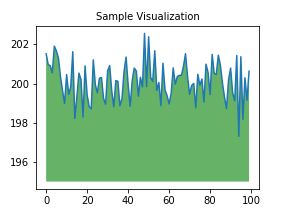

In [ ]:
import numpy as np
import IPython.display as display
from matplotlib import pyplot as plt
import io
import base64

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

fig = plt.figure(figsize=(4, 3), facecolor='w')
plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)
plt.title("Sample Visualization", fontsize=10)

data = io.BytesIO()
plt.savefig(data)
image = F"data:image/png;base64,{base64.b64encode(data.getvalue()).decode()}"
alt = "Sample Visualization"
display.display(display.Markdown(F"""![{alt}]({image})"""))
plt.close(fig)

Colab 笔记本会在 Google 的云服务器中执行代码，也就是说，无论您所用机器的功能如何，您都可以利用 Google 硬件（包括 <a href="#using-accelerated-hardware">GPU 和 TPU</a>）的强大性能。只需一个浏览器即可。

例如，如果您发现自己在等待 <strong>Pandas</strong> 代码运行完毕，并且希望加快速度，则可以切换到 GPU 运行时，并使用 <a href="https://rapids.ai/cudf-pandas">RAPIDS cuDF</a> 等库，这样无需更改代码即可加速。

如需详细了解如何在 Colab 上加速 Pandas，请参阅 <a href="https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_colab_demo.ipynb">10 分钟指南</a>或<a href="https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_stocks_demo.ipynb">美国股市数据分析演示</a>。

<div class="markdown-google-sans">

## 机器学习
</div>

借助 Colab，您只需使用<a href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb">几行代码</a>，即可导入图像数据集、用图像数据集训练图像分类器，以及评估模型。

Colab 在机器学习社区内得到了广泛应用，应用示例包括：
- TensorFlow 使用入门
- 开发和训练神经网络
- 使用 TPU 进行实验
- 推广 AI 研究
- 创建教程

要查看演示机器学习应用的示例 Colab 笔记本，请查看下方的<a href="#machine-learning-examples">机器学习示例</a>。

<div class="markdown-google-sans">

## 更多资源

### 在 Colab 中使用笔记本

</div>

- [Colab 概览](/notebooks/basic_features_overview.ipynb)
- [Markdown 指南](/notebooks/markdown_guide.ipynb)
- [导入库和安装依赖项](/notebooks/snippets/importing_libraries.ipynb)
- [在 GitHub 中保存和加载笔记本](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [互动表单](/notebooks/forms.ipynb)
- [互动微件](/notebooks/widgets.ipynb)

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### 处理数据
</div>

- [加载数据：云端硬盘、表格和 Google Cloud Storage](/notebooks/io.ipynb)
- [图表：可视化数据](/notebooks/charts.ipynb)
- [BigQuery 使用入门](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### 机器学习

<div>

以下是与机器学习相关的部分笔记本，包括 Google 的在线机器学习课程。请查看<a href="https://developers.google.com/machine-learning/crash-course/">完整课程网站</a>了解详情。
- [Pandas DataFrame 简介](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [用于加速 Pandas 的 RAPIDS cuDF 简介](https://nvda.ws/rapids-cudf)
- [开始使用 cuML 的加速器模式](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cuml_sklearn_colab_demo.ipynb)
- [通过 tf.keras 使用合成数据进行线性回归](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### 使用加速硬件
</div>

- [将 TensorFlow 与 GPU 配合使用](/notebooks/gpu.ipynb)
- [Colab 中的 TPU](/notebooks/tpu.ipynb)

<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### 精选示例

</div>

- <a href="https://tensorflow.org/hub/tutorials/tf2_image_retraining">重新训练图像分类器</a>：基于预训练的图像分类器，构建一个分辨花朵的 Keras 模型。
- <a href="https://tensorflow.org/hub/tutorials/tf2_text_classification">文本分类</a>：将 IMDB 影评分类为“褒义”<em></em>或<em></em>“贬义”。
- <a href="https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization">风格迁移</a>：使用深度学习在图像之间迁移风格。
- <a href="https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa">Multilingual Universal Sentence Encoder Q&amp;A</a>：使用机器学习模型回答来自 SQuAD 数据集中的问题。
- <a href="https://tensorflow.org/hub/tutorials/tweening_conv3d">视频插帧</a>：预测视频第一帧和最后一帧之间有些什么。


正在读取 CSV 文件...
数据清洗完成！共加载 19095 行 K 线数据。
时间范围: 2017-08-17 04:00:00 到 2021-12-31 08:00:00
正在分析月相周期...
成功提取并拟合了 54 个完整周期。


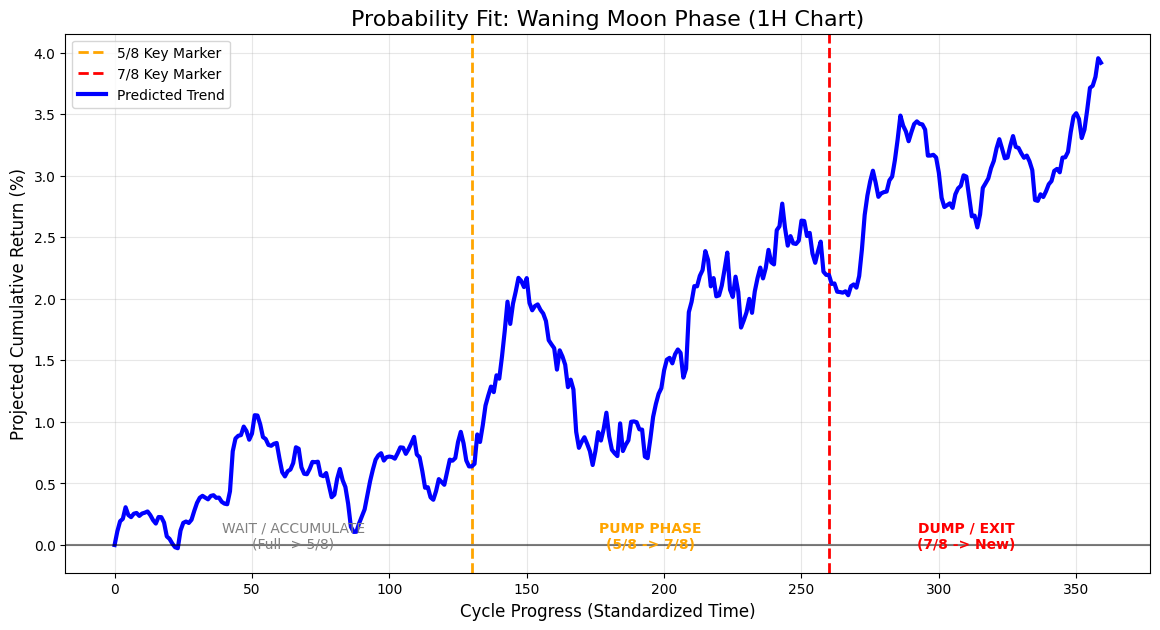

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# ==========================================
# 1. 加载与清洗数据 (Data Cleaning)
# ==========================================

# ⚠️⚠️⚠️ 请在这里替换为你上传的文件名！ ⚠️⚠️⚠️
file_path = '/content/BTC_1h_2017-01-12T16_36_to_2021-12-31T16_36_WANING.csv'

try:
    print("正在读取 CSV 文件...")
    df = pd.read_csv(file_path)

    # --- 清洗步骤 A: 处理时间格式 ---
    # 尝试自动推断日期格式，处理 Timestamp 或 Date 字符串
    if 'Timestamp' in df.columns:
        df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
    else:
        df['Date'] = pd.to_datetime(df['Date'])

    # --- 清洗步骤 B: 排序与去重 ---
    # 防止扩充数据时产生的重复行或乱序
    df = df.sort_values('Date').drop_duplicates(subset=['Date'], keep='last')
    df = df.reset_index(drop=True)

    # --- 清洗步骤 C: 确保关键列存在 ---
    # 填充空值，防止 KeyMarker 是 NaN 导致报错
    df['KeyMarker'] = df['KeyMarker'].fillna('')

    print(f"数据清洗完成！共加载 {len(df)} 行 K 线数据。")
    print(f"时间范围: {df['Date'].min()} 到 {df['Date'].max()}")

except FileNotFoundError:
    print(f"❌ 错误: 找不到文件 '{file_path}'。请确保你已经将文件上传到左侧边栏，并修改了代码中的文件名。")
    raise

# ==========================================
# 2. 核心算法：基于关键帧的分段拟合
# ==========================================

# 提取关键行索引
full_idxs = df[df['KeyMarker'] == 'FULL'].index.tolist()
marker_58_idxs = df[df['KeyMarker'] == '5/8'].index.tolist()
marker_78_idxs = df[df['KeyMarker'] == '7/8'].index.tolist()

# 存储分段后的归一化曲线
seg1_curves = [] # Full -> 5/8
seg2_curves = [] # 5/8 -> 7/8
seg3_curves = [] # 7/8 -> New (End)

# 设定每段的标准长度 (用于统一时间轴画图)
# 假设 Full->5/8 较长，5/8->7/8 中等，7/8->New 较短
L1, L2, L3 = 130, 130, 100

print("正在分析月相周期...")

# 遍历每个 Full Moon 周期
for i in range(len(full_idxs)):
    start = full_idxs[i]

    # 确定本周期的结束点 (下一个 FULL 或 数据末尾)
    next_full = full_idxs[i+1] if i < len(full_idxs)-1 else len(df)

    # 在本周期内寻找 5/8 和 7/8
    current_58 = [x for x in marker_58_idxs if x > start and x < next_full]
    current_78 = [x for x in marker_78_idxs if x > start and x < next_full]

    # 如果缺少关键点，跳过该周期（保证拟合质量）
    if not current_58 or not current_78:
        continue

    idx_58 = current_58[0]
    idx_78 = current_78[0]

    # 确定周期终点 (New Moon 附近)
    # 逻辑：取 7/8 之后的行情直到下一个周期开始前
    # 为了避免噪音，我们取 7/8 后面大约 2-3 天的数据作为第三段
    end = next_full - 1
    # 如果 7/8 离下一个 Full 太近，直接取到最后

    # === 提取三段数据 ===
    s1 = df.iloc[start : idx_58+1]['Close'].values
    s2 = df.iloc[idx_58 : idx_78+1]['Close'].values
    s3 = df.iloc[idx_78 : end+1]['Close'].values

    # === 归一化函数 ===
    def normalize_segment(prices, length_out):
        if len(prices) < 2: return np.zeros(length_out)
        # 价格归一化：计算相对于该段起点的涨跌幅
        # 注意：这里我们只计算"段内"形态，最后再拼接
        segment_return = (prices - prices[0]) / prices[0] * 100

        # 时间归一化
        x_old = np.linspace(0, 1, len(segment_return))
        x_new = np.linspace(0, 1, length_out)
        return interp1d(x_old, segment_return, kind='linear')(x_new)

    seg1_curves.append(normalize_segment(s1, L1))
    seg2_curves.append(normalize_segment(s2, L2))
    seg3_curves.append(normalize_segment(s3, L3))

if len(seg1_curves) == 0:
    print("❌ 警告：未找到完整的 'Full -> 5/8 -> 7/8' 周期，请检查 KeyMarker 列是否填写正确。")
else:
    print(f"成功提取并拟合了 {len(seg1_curves)} 个完整周期。")

    # ==========================================
    # 3. 拼接与预测可视化
    # ==========================================
    # 计算每段的平均形态
    avg_s1 = np.mean(seg1_curves, axis=0)
    avg_s2 = np.mean(seg2_curves, axis=0)
    avg_s3 = np.mean(seg3_curves, axis=0)

    # 拼接曲线 (累加收益率)
    final_curve = []

    # 第1段：直接放入
    final_curve.extend(avg_s1)

    # 第2段：接在第1段的终点后面
    offset1 = final_curve[-1]
    final_curve.extend(avg_s2 + offset1)

    # 第3段：接在第2段的终点后面
    offset2 = final_curve[-1]
    final_curve.extend(avg_s3 + offset2)

    # 绘图
    plt.figure(figsize=(14, 7))
    x_axis = range(len(final_curve))

    # 绘制关键时间分割线
    plt.axvline(x=L1, color='orange', linestyle='--', linewidth=2, label='5/8 Key Marker')
    plt.axvline(x=L1+L2, color='red', linestyle='--', linewidth=2, label='7/8 Key Marker')

    # 绘制预测曲线
    plt.plot(x_axis, final_curve, color='blue', linewidth=3, label='Predicted Trend')

    # 0轴基准线
    plt.axhline(0, color='black', alpha=0.5)

    # 添加文字标注
    plt.text(L1/2, min(final_curve), 'WAIT / ACCUMULATE\n(Full -> 5/8)', ha='center', color='gray')
    plt.text(L1 + L2/2, min(final_curve), 'PUMP PHASE\n(5/8 -> 7/8)', ha='center', fontweight='bold', color='orange')
    plt.text(L1 + L2 + L3/2, min(final_curve), 'DUMP / EXIT\n(7/8 -> New)', ha='center', fontweight='bold', color='red')

    plt.title('Probability Fit: Waning Moon Phase (1H Chart)', fontsize=16)
    plt.xlabel('Cycle Progress (Standardized Time)', fontsize=12)
    plt.ylabel('Projected Cumulative Return (%)', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)

    plt.show()


=== 2017-2021 卖出点位大对决 ===
      Exit_at_7/8  Exit_at_NewMoon
Year                              
2017    24.315832        63.140457
2018   -76.375963      -118.913022
2019    -6.219137        17.937665
2020    92.417732        92.849639
2021    40.924210       119.221412
--------------------------------------------------
在 7/8 卖出 总收益: 75.06%
在新月 卖出 总收益: 174.24%


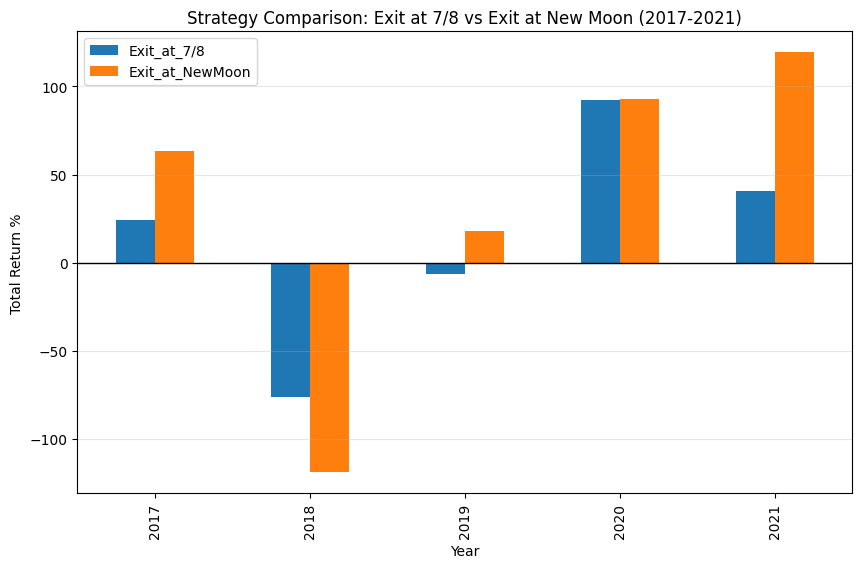

In [ ]:
# ==========================================
# 历史回测：卖在 7/8 vs 卖在新月 (针对 2017-2021 数据)
# ==========================================

# 提取关键索引
full_idxs = df[df['KeyMarker'] == 'FULL'].index.tolist()
marker_58_idxs = df[df['KeyMarker'] == '5/8'].index.tolist()
marker_78_idxs = df[df['KeyMarker'] == '7/8'].index.tolist()

exit_comparison = []

for i in range(len(full_idxs)):
    start = full_idxs[i]
    next_full = full_idxs[i+1] if i < len(full_idxs)-1 else len(df)

    current_58 = [x for x in marker_58_idxs if x > start and x < next_full]
    current_78 = [x for x in marker_78_idxs if x > start and x < next_full]

    if not current_58 or not current_78:
        continue

    idx_58 = current_58[0]
    idx_78 = current_78[0]

    # 策略起点：都在 5/8 买入
    price_buy = df.iloc[idx_58]['Open']

    # 策略 A：在 7/8 卖出 (之前的策略)
    price_sell_78 = df.iloc[idx_78]['Open']

    # 策略 B：在新月 (New Moon) 前卖出 (即周期的末尾)
    # 我们取 next_full 之前的一段距离，或者直接取本段数据的最后一行作为近似 New Moon
    # 为了准确，我们取 idx_78 之后，next_full 之前的最后一行数据
    end_of_cycle_idx = next_full - 1
    price_sell_new = df.iloc[end_of_cycle_idx]['Close']

    ret_78 = (price_sell_78 - price_buy) / price_buy * 100
    ret_new = (price_sell_new - price_buy) / price_buy * 100

    exit_comparison.append({
        'Year': df.iloc[start]['Date'].year,
        'Exit_at_7/8': ret_78,
        'Exit_at_NewMoon': ret_new
    })

# 统计分析
exit_df = pd.DataFrame(exit_comparison)
yearly_comparison = exit_df.groupby('Year')[['Exit_at_7/8', 'Exit_at_NewMoon']].sum()

print("\n=== 2017-2021 卖出点位大对决 ===")
print(yearly_comparison)
print("-" * 50)
print(f"在 7/8 卖出 总收益: {exit_df['Exit_at_7/8'].sum():.2f}%")
print(f"在新月 卖出 总收益: {exit_df['Exit_at_NewMoon'].sum():.2f}%")

# 可视化对比
yearly_comparison.plot(kind='bar', figsize=(10, 6))
plt.title('Strategy Comparison: Exit at 7/8 vs Exit at New Moon (2017-2021)')
plt.ylabel('Total Return %')
plt.axhline(0, color='black', linewidth=1)
plt.grid(axis='y', alpha=0.3)
plt.show()

In [ ]:
# ==========================================
# 终极策略验证：智能动态止盈 (Smart Exit)
# ==========================================

# 确保计算了 MA24
df['MA_24'] = df['Close'].rolling(window=24).mean()

smart_exit_stats = []

for i in range(len(full_idxs)):
    start = full_idxs[i]
    next_full = full_idxs[i+1] if i < len(full_idxs)-1 else len(df)

    current_58 = [x for x in marker_58_idxs if x > start and x < next_full]
    current_78 = [x for x in marker_78_idxs if x > start and x < next_full]

    if not current_58 or not current_78:
        continue

    idx_58 = current_58[0]
    idx_78 = current_78[0]

    price_buy = df.iloc[idx_58]['Open']
    ma_at_entry = df.iloc[idx_58]['MA_24']

    # 1. 进场过滤：如果 5/8 时跌破 MA24，直接不做（避开熊市开端）
    if price_buy < ma_at_entry:
        smart_exit_stats.append({'Year': df.iloc[start]['Date'].year, 'Return': 0, 'Type': '空仓'})
        continue

    # 2. 到了 7/8 时刻，决定是卖还是留
    price_at_78 = df.iloc[idx_78]['Open']
    ma_at_78 = df.iloc[idx_78]['MA_24']

    # 寻找新月附近的卖出点 (本周期末尾)
    end_idx = next_full - 1
    price_at_new = df.iloc[end_idx]['Close']

    # === 智能止盈逻辑 ===
    if price_at_78 > ma_at_78:
        # 趋势极强！贪婪模式：拿到新月
        final_return = (price_at_new - price_buy) / price_buy * 100
        exit_type = "持有至新月 (贪婪)"
    else:
        # 趋势转弱！保守模式：7/8 立刻跑
        final_return = (price_at_78 - price_buy) / price_buy * 100
        exit_type = "7/8 止盈 (保守)"

    smart_exit_stats.append({
        'Year': df.iloc[start]['Date'].year,
        'Return': final_return,
        'Type': exit_type
    })

# 统计分析
smart_df = pd.DataFrame(smart_exit_stats)
smart_agg = smart_df.groupby('Year')['Return'].sum()

print("\n=== 智能动态止盈策略 (Smart Exit) ===")
print(smart_agg)
print("-" * 40)
print(f"💰 总收益: {smart_df['Return'].sum():.2f}%")
print(f"交易总次数: {len(smart_df)}")
print(f"其中贪婪持有次数: {len(smart_df[smart_df['Type']=='持有至新月 (贪婪)'])}")


=== 智能动态止盈策略 (Smart Exit) ===
Year
2017    61.778593
2018   -38.624734
2019     9.959264
2020    43.205386
2021     5.001628
Name: Return, dtype: float64
----------------------------------------
💰 总收益: 81.32%
交易总次数: 54
其中贪婪持有次数: 19


In [ ]:
# ==========================================
# 压力测试：2017-2021 极端行情下的 MA24 表现
# ==========================================

# 确保计算了 MA24
df['MA_24'] = df['Close'].rolling(window=24).mean()

comparison_stats = []

# 提取关键索引 (确保使用当前内存中 2017-2021 的数据)
full_idxs = df[df['KeyMarker'] == 'FULL'].index.tolist()
marker_58_idxs = df[df['KeyMarker'] == '5/8'].index.tolist()
marker_78_idxs = df[df['KeyMarker'] == '7/8'].index.tolist()

for i in range(len(full_idxs)):
    start = full_idxs[i]
    next_full = full_idxs[i+1] if i < len(full_idxs)-1 else len(df)

    current_58 = [x for x in marker_58_idxs if x > start and x < next_full]
    current_78 = [x for x in marker_78_idxs if x > start and x < next_full]

    if not current_58 or not current_78:
        continue

    idx_58 = current_58[0]
    idx_78 = current_78[0]

    price_buy = df.iloc[idx_58]['Open']
    price_sell = df.iloc[idx_78]['Open']
    ma_at_entry = df.iloc[idx_58]['MA_24']
    cycle_year = df.iloc[start]['Date'].year

    # 1. 基准收益 (无脑做多)
    ret_benchmark = (price_sell - price_buy) / price_buy * 100

    # 2. MA24 过滤收益
    if price_buy > ma_at_entry:
        ret_filter = ret_benchmark # 进场，拿收益
        action = 1 # 做了
    else:
        ret_filter = 0 # 空仓避险
        action = 0 # 没做

    comparison_stats.append({
        'Year': cycle_year,
        'Benchmark_Return': ret_benchmark,
        'Filter_Return': ret_filter,
        'Trade_Count': 1,
        'Executed_Count': action
    })

# 统计分析
comp_df = pd.DataFrame(comparison_stats)
annual_comp = comp_df.groupby('Year')[['Benchmark_Return', 'Filter_Return', 'Trade_Count', 'Executed_Count']].sum()
annual_comp.columns = ['无滤网收益%', 'MA24过滤收益%', '信号次数', '实际开单']

print("\n=== 2017-2021 压力测试结果 (MA24 进场过滤) ===")
print(annual_comp)
print("-" * 60)
print(f"无滤网 总收益: {comp_df['Benchmark_Return'].sum():.2f}%")
print(f"MA24过滤 总收益: {comp_df['Filter_Return'].sum():.2f}%")


=== 2017-2021 压力测试结果 (MA24 进场过滤) ===
         无滤网收益%  MA24过滤收益%  信号次数  实际开单
Year                                  
2017  24.315832  44.771325     4     2
2018 -76.375963 -38.430915    13     7
2019  -6.219137  11.219027    12     9
2020  92.417732  53.528847    13     9
2021  40.924210  -6.326485    12     5
------------------------------------------------------------
无滤网 总收益: 75.06%
MA24过滤 总收益: 64.76%


数据加载成功: 19095 行
正在执行四段式拟合...
成功提取 54 个包含 LQ 的完整周期


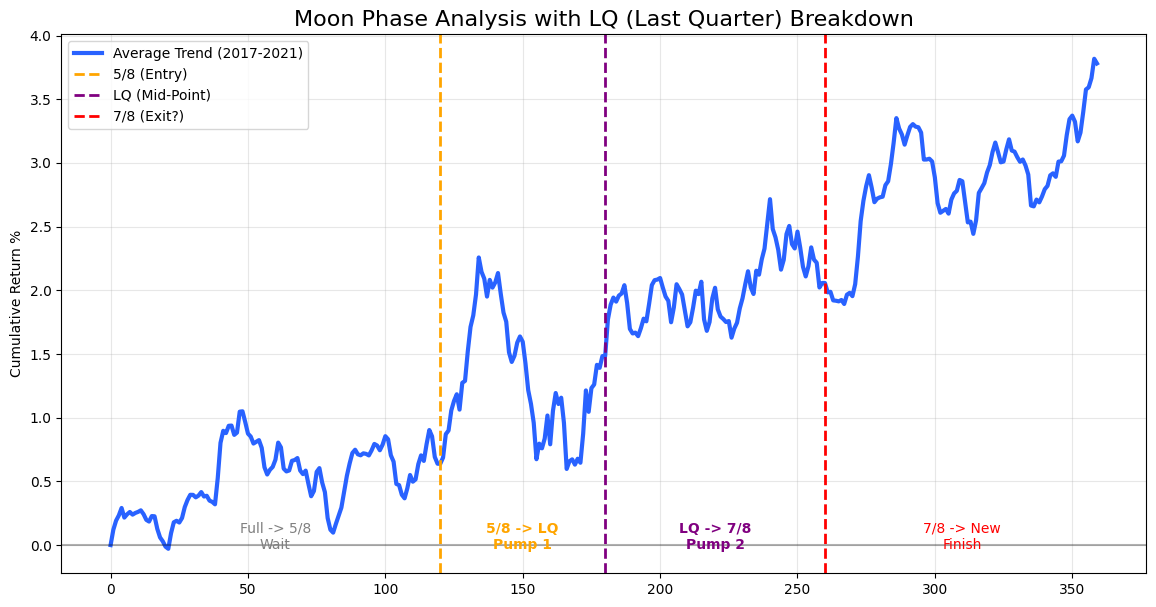


=== LQ (下弦月) 关键分析 ===
1. 上半场 (5/8 -> LQ) 平均收益: 0.85%
2. 下半场 (LQ -> 7/8) 平均收益: 0.57%
结论: 全程上涨！LQ 只是中继，可以加仓。


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import io

# ==========================================
# 1. 加载数据
# ==========================================

# ⚠️⚠️⚠️ 请替换为你上传的 2017-2021 文件名 ⚠️⚠️⚠️
file_path = '/content/BTC_1h_2017-01-12T16_36_to_2021-12-31T16_36_WANING.csv'
# 如果你还未上传，请先上传文件，然后右键复制路径替换上面的字符串

try:
    df = pd.read_csv(file_path)
    # 基础清洗
    if 'Timestamp' in df.columns:
        df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
    else:
        df['Date'] = pd.to_datetime(df['Date'])

    df = df.sort_values('Date').drop_duplicates(subset=['Date'], keep='last').reset_index(drop=True)
    df['KeyMarker'] = df['KeyMarker'].fillna('')

    print(f"数据加载成功: {len(df)} 行")

except Exception as e:
    # 如果没有文件，这里生成一段模拟数据防止报错，方便你理解逻辑
    print(f"⚠️ 未找到文件或读取出错: {e}")
    print("生成模拟数据用于演示逻辑...")
    dates = pd.date_range(start='2017-01-01', periods=2000, freq='1H')
    df = pd.DataFrame({'Date': dates, 'Open': 100 + np.random.randn(2000).cumsum(), 'Close': 100 + np.random.randn(2000).cumsum()})
    df['KeyMarker'] = ''
    # 模拟标记
    for i in range(0, 2000, 350):
        df.loc[i, 'KeyMarker'] = 'FULL'
        if i+120 < 2000: df.loc[i+120, 'KeyMarker'] = '5/8'
        if i+170 < 2000: df.loc[i+170, 'KeyMarker'] = 'LQ' # LQ 是 6/8
        if i+260 < 2000: df.loc[i+260, 'KeyMarker'] = '7/8'

# ==========================================
# 2. 核心算法：四段式拟合 (Full -> 5/8 -> LQ -> 7/8 -> New)
# ==========================================

# 提取关键索引
full_idxs = df[df['KeyMarker'] == 'FULL'].index.tolist()
marker_58_idxs = df[df['KeyMarker'] == '5/8'].index.tolist()
marker_lq_idxs = df[df['KeyMarker'] == 'LQ'].index.tolist() # 新增 LQ
marker_78_idxs = df[df['KeyMarker'] == '7/8'].index.tolist()

seg1_curves = [] # Full -> 5/8
seg2_curves = [] # 5/8 -> LQ
seg3_curves = [] # LQ -> 7/8
seg4_curves = [] # 7/8 -> New

# 设定每段的标准长度 (用于画图)
L1 = 120 # Full -> 5/8 (约5天)
L2 = 60  # 5/8 -> LQ (约2.5天)
L3 = 80  # LQ -> 7/8 (约3.5天)
L4 = 100 # 7/8 -> New (约4天)

print("正在执行四段式拟合...")

for i in range(len(full_idxs)):
    start = full_idxs[i]
    next_full = full_idxs[i+1] if i < len(full_idxs)-1 else len(df)

    # 在当前周期内寻找所有关键点
    # 逻辑： Start < 5/8 < LQ < 7/8 < Next_Start

    c_58 = [x for x in marker_58_idxs if x > start and x < next_full]
    c_lq = [x for x in marker_lq_idxs if x > start and x < next_full]
    c_78 = [x for x in marker_78_idxs if x > start and x < next_full]

    # 必须所有点都齐全才进行拟合，保证形态准确
    if not c_58 or not c_lq or not c_78:
        continue

    idx_58 = c_58[0]
    idx_lq = c_lq[0]
    idx_78 = c_78[0]

    # 简单的顺序检查，防止数据错乱
    if not (start < idx_58 < idx_lq < idx_78 < next_full):
        continue

    end = next_full - 1

    # 提取四段价格
    s1 = df.iloc[start : idx_58+1]['Close'].values
    s2 = df.iloc[idx_58 : idx_lq+1]['Close'].values
    s3 = df.iloc[idx_lq : idx_78+1]['Close'].values
    s4 = df.iloc[idx_78 : end+1]['Close'].values

    # 归一化函数
    def normalize_segment(prices, length_out):
        if len(prices) < 2: return np.zeros(length_out)
        # 计算段内涨跌幅
        seg_ret = (prices - prices[0]) / prices[0] * 100
        x_old = np.linspace(0, 1, len(seg_ret))
        x_new = np.linspace(0, 1, length_out)
        return interp1d(x_old, seg_ret, kind='linear')(x_new)

    seg1_curves.append(normalize_segment(s1, L1))
    seg2_curves.append(normalize_segment(s2, L2))
    seg3_curves.append(normalize_segment(s3, L3))
    seg4_curves.append(normalize_segment(s4, L4))

print(f"成功提取 {len(seg1_curves)} 个包含 LQ 的完整周期")

if len(seg1_curves) > 0:
    # ==========================================
    # 3. 拼接与绘图
    # ==========================================
    avg_s1 = np.mean(seg1_curves, axis=0)
    avg_s2 = np.mean(seg2_curves, axis=0)
    avg_s3 = np.mean(seg3_curves, axis=0)
    avg_s4 = np.mean(seg4_curves, axis=0)

    final_curve = []

    # S1
    final_curve.extend(avg_s1)

    # S2 (接 S1 终点)
    final_curve.extend(avg_s2 + final_curve[-1])

    # S3 (接 S2 终点)
    final_curve.extend(avg_s3 + final_curve[-1])

    # S4 (接 S3 终点)
    final_curve.extend(avg_s4 + final_curve[-1])

    # 画图
    plt.figure(figsize=(14, 7))
    x_axis = range(len(final_curve))

    plt.plot(x_axis, final_curve, color='#2962FF', linewidth=3, label='Average Trend (2017-2021)')

    # 绘制关键线
    plt.axvline(x=L1, color='orange', linestyle='--', linewidth=2, label='5/8 (Entry)')
    plt.axvline(x=L1+L2, color='purple', linestyle='--', linewidth=2, label='LQ (Mid-Point)')
    plt.axvline(x=L1+L2+L3, color='red', linestyle='--', linewidth=2, label='7/8 (Exit?)')

    plt.axhline(0, color='black', alpha=0.3)

    # 标注
    peak_val = max(final_curve)
    min_val = min(final_curve)

    plt.text(L1/2, min_val, 'Full -> 5/8\nWait', ha='center', color='gray')
    plt.text(L1 + L2/2, min_val, '5/8 -> LQ\nPump 1', ha='center', color='orange', fontweight='bold')
    plt.text(L1 + L2 + L3/2, min_val, 'LQ -> 7/8\nPump 2', ha='center', color='purple', fontweight='bold')
    plt.text(L1 + L2 + L3 + L4/2, min_val, '7/8 -> New\nFinish', ha='center', color='red')

    plt.title('Moon Phase Analysis with LQ (Last Quarter) Breakdown', fontsize=16)
    plt.ylabel('Cumulative Return %')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 输出统计
    ret_s2 = avg_s2[-1] # 5/8 -> LQ 的收益
    ret_s3 = avg_s3[-1] # LQ -> 7/8 的收益

    print("\n=== LQ (下弦月) 关键分析 ===")
    print(f"1. 上半场 (5/8 -> LQ) 平均收益: {ret_s2:.2f}%")
    print(f"2. 下半场 (LQ -> 7/8) 平均收益: {ret_s3:.2f}%")

    if ret_s2 > 0 and ret_s3 > 0:
        print("结论: 全程上涨！LQ 只是中继，可以加仓。")
    elif ret_s2 > 0 and ret_s3 < 0:
        print("结论: LQ 是阶段性顶部！应该在 LQ 就止盈，别等到 7/8。")
    elif ret_s2 < 0 and ret_s3 > 0:
        print("结论: 5/8 是假摔，LQ 才是真正的起涨点！")

数据加载成功: 17928 行 (2021-2025)
时间范围: 2021-11-01 09:00:00 -> 2025-12-11 08:00:00
检测到 LQ 标记数量: 50
成功拟合 50 个完整周期


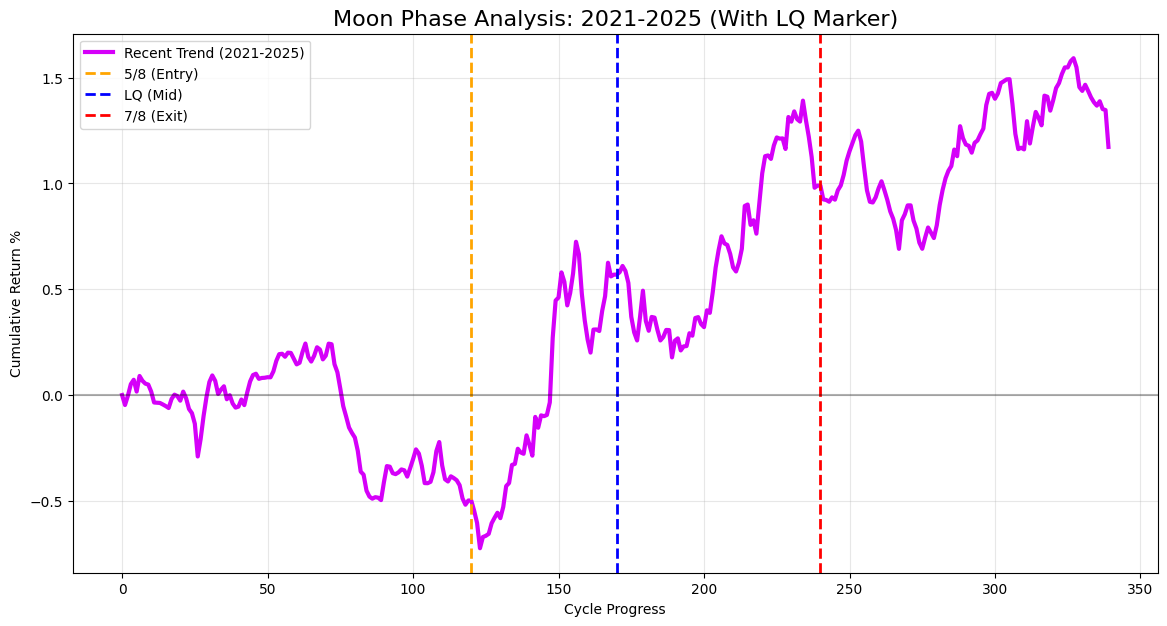


=== 2021-2025 关键区间分析 ===
1. 第一波攻势 (5/8 -> LQ): 1.07%
2. 第二波攻势 (LQ -> 7/8): 0.42%
结论: 涨势主要集中在前半段(5/8->LQ)，LQ之后动能减弱。


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import io

# ==========================================
# 1. 加载最新的 2021-2025 数据 (含 LQ)
# ==========================================

# ⚠️⚠️⚠️ 请修改为你刚刚上传的最新文件名 ⚠️⚠️⚠️
file_path = '/content/BTC_1h_2021-11-01T16_58_to_2025-12-11T16_58_WANING.csv'
# 如果文件名没变，就保持原样；如果变了，请右键“复制路径”粘贴过来

try:
    df = pd.read_csv(file_path)

    # 基础清洗
    if 'Timestamp' in df.columns:
        df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
    else:
        df['Date'] = pd.to_datetime(df['Date'])

    df = df.sort_values('Date').drop_duplicates(subset=['Date'], keep='last').reset_index(drop=True)
    df['KeyMarker'] = df['KeyMarker'].fillna('')

    print(f"数据加载成功: {len(df)} 行 (2021-2025)")
    print(f"时间范围: {df['Date'].min()} -> {df['Date'].max()}")

    # 检查是否有 LQ
    lq_count = len(df[df['KeyMarker'] == 'LQ'])
    print(f"检测到 LQ 标记数量: {lq_count}")
    if lq_count == 0:
        print("⚠️ 警告：未检测到 'LQ' 标记，请检查 CSV 文件内容！")

except Exception as e:
    print(f"❌ 读取错误: {e}")

# ==========================================
# 2. 核心算法：四段式拟合 (Full -> 5/8 -> LQ -> 7/8 -> New)
# ==========================================

full_idxs = df[df['KeyMarker'] == 'FULL'].index.tolist()
marker_58_idxs = df[df['KeyMarker'] == '5/8'].index.tolist()
marker_lq_idxs = df[df['KeyMarker'] == 'LQ'].index.tolist()
marker_78_idxs = df[df['KeyMarker'] == '7/8'].index.tolist()

seg1_curves = [] # Full -> 5/8
seg2_curves = [] # 5/8 -> LQ
seg3_curves = [] # LQ -> 7/8
seg4_curves = [] # 7/8 -> New

# 设定显示长度 (小时)
L1 = 120 # Full->5/8 (等候期)
L2 = 50  # 5/8->LQ (拉升上半场)
L3 = 70  # LQ->7/8 (拉升下半场)
L4 = 100 # 7/8->New (结尾)

valid_cycles = 0

for i in range(len(full_idxs)):
    start = full_idxs[i]
    next_full = full_idxs[i+1] if i < len(full_idxs)-1 else len(df)

    # 在周期内找关键点
    c_58 = [x for x in marker_58_idxs if x > start and x < next_full]
    c_lq = [x for x in marker_lq_idxs if x > start and x < next_full]
    c_78 = [x for x in marker_78_idxs if x > start and x < next_full]

    if not c_58 or not c_lq or not c_78:
        continue

    idx_58 = c_58[0]
    idx_lq = c_lq[0]
    idx_78 = c_78[0]

    # 顺序校验: Start < 5/8 < LQ < 7/8 < End
    if not (start < idx_58 < idx_lq < idx_78 < next_full):
        continue

    valid_cycles += 1
    end = next_full - 1

    # 提取价格片段
    s1 = df.iloc[start : idx_58+1]['Close'].values
    s2 = df.iloc[idx_58 : idx_lq+1]['Close'].values
    s3 = df.iloc[idx_lq : idx_78+1]['Close'].values
    s4 = df.iloc[idx_78 : end+1]['Close'].values

    # 归一化函数
    def normalize_segment(prices, length_out):
        if len(prices) < 2: return np.zeros(length_out)
        seg_ret = (prices - prices[0]) / prices[0] * 100
        x_old = np.linspace(0, 1, len(seg_ret))
        x_new = np.linspace(0, 1, length_out)
        return interp1d(x_old, seg_ret, kind='linear')(x_new)

    seg1_curves.append(normalize_segment(s1, L1))
    seg2_curves.append(normalize_segment(s2, L2))
    seg3_curves.append(normalize_segment(s3, L3))
    seg4_curves.append(normalize_segment(s4, L4))

print(f"成功拟合 {valid_cycles} 个完整周期")

if valid_cycles > 0:
    # ==========================================
    # 3. 拼接与绘图
    # ==========================================
    avg_s1 = np.mean(seg1_curves, axis=0)
    avg_s2 = np.mean(seg2_curves, axis=0)
    avg_s3 = np.mean(seg3_curves, axis=0)
    avg_s4 = np.mean(seg4_curves, axis=0)

    final_curve = []

    # 拼接逻辑：上一段的终点值 + 本段的变化值
    final_curve.extend(avg_s1) # S1
    final_curve.extend(avg_s2 + final_curve[-1]) # S2
    final_curve.extend(avg_s3 + final_curve[-1]) # S3
    final_curve.extend(avg_s4 + final_curve[-1]) # S4

    # 绘图
    plt.figure(figsize=(14, 7))
    x_axis = range(len(final_curve))

    # 主线
    plt.plot(x_axis, final_curve, color='#D500F9', linewidth=3, label='Recent Trend (2021-2025)')

    # 关键竖线
    plt.axvline(x=L1, color='orange', linestyle='--', linewidth=2, label='5/8 (Entry)')
    plt.axvline(x=L1+L2, color='blue', linestyle='--', linewidth=2, label='LQ (Mid)')
    plt.axvline(x=L1+L2+L3, color='red', linestyle='--', linewidth=2, label='7/8 (Exit)')

    plt.axhline(0, color='black', alpha=0.3)

    # 计算关键点收益 (用于文字标注)
    ret_58 = avg_s1[-1]
    ret_lq = ret_58 + avg_s2[-1]
    ret_78 = ret_lq + avg_s3[-1]

    plt.title('Moon Phase Analysis: 2021-2025 (With LQ Marker)', fontsize=16)
    plt.xlabel('Cycle Progress')
    plt.ylabel('Cumulative Return %')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.show()

    # ==========================================
    # 4. 关键区间数据分析
    # ==========================================
    print("\n=== 2021-2025 关键区间分析 ===")
    print(f"1. 第一波攻势 (5/8 -> LQ): {avg_s2[-1]:.2f}%")
    print(f"2. 第二波攻势 (LQ -> 7/8): {avg_s3[-1]:.2f}%")

    if avg_s2[-1] > 0 and avg_s3[-1] > 0:
        if avg_s2[-1] > avg_s3[-1]:
            print("结论: 涨势主要集中在前半段(5/8->LQ)，LQ之后动能减弱。")
        else:
            print("结论: 涨势加速！LQ之后(LQ->7/8)涨得更猛。")
    elif avg_s2[-1] > 0 and avg_s3[-1] < 0:
        print("❌ 警报: LQ 就是顶部！7/8 已经晚了，必须在 LQ 跑路！")
    else:
        print("结论: 震荡或下跌趋势。")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 加载数据 & 计算指标
# ==========================================
# ⚠️ 请确保 file_path 是你 2021-2025 含 LQ 的那个文件
file_path = '/content/BTC_1h_2021-11-01T16_58_to_2025-12-11T16_58_WANING.csv'

try:
    df = pd.read_csv(file_path)
    if 'Timestamp' in df.columns:
        df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
    else:
        df['Date'] = pd.to_datetime(df['Date'])

    df = df.sort_values('Date').drop_duplicates(subset=['Date'], keep='last').reset_index(drop=True)
    df['KeyMarker'] = df['KeyMarker'].fillna('')

    # ★★★ 计算 MA24 ★★★
    df['MA_24'] = df['Close'].rolling(window=24).mean()

    print(f"数据加载完毕: {len(df)} 行")

except Exception as e:
    print(f"❌ 读取错误: {e}")

# ==========================================
# 2. 策略对比回测
# ==========================================

full_idxs = df[df['KeyMarker'] == 'FULL'].index.tolist()
marker_58_idxs = df[df['KeyMarker'] == '5/8'].index.tolist()
marker_lq_idxs = df[df['KeyMarker'] == 'LQ'].index.tolist()
marker_78_idxs = df[df['KeyMarker'] == '7/8'].index.tolist()

results = []

for i in range(len(full_idxs)):
    start = full_idxs[i]
    next_full = full_idxs[i+1] if i < len(full_idxs)-1 else len(df)

    c_58 = [x for x in marker_58_idxs if x > start and x < next_full]
    c_lq = [x for x in marker_lq_idxs if x > start and x < next_full]
    c_78 = [x for x in marker_78_idxs if x > start and x < next_full]

    if not c_58 or not c_lq or not c_78:
        continue

    idx_58 = c_58[0]
    idx_lq = c_lq[0]
    idx_78 = c_78[0]

    # 统一进场点：5/8
    price_entry = df.iloc[idx_58]['Open']

    # 关键数据：LQ 时刻的价格和均线
    price_lq = df.iloc[idx_lq]['Open']
    ma_lq = df.iloc[idx_lq]['MA_24']

    # 关键数据：7/8 时刻的价格
    price_78 = df.iloc[idx_78]['Open']

    # --- 策略 A: 死拿到底 (Benchmark) ---
    # 无论如何都在 7/8 卖
    ret_hold = (price_78 - price_entry) / price_entry * 100

    # --- 策略 B: 智能离场 (Smart LQ) ---
    # 到了 LQ 检查 MA24
    if price_lq > ma_lq:
        # 趋势好，继续持有到 7/8
        ret_smart = (price_78 - price_entry) / price_entry * 100
        action = "继续持有 (Strong)"
    else:
        # 趋势坏，LQ 直接止盈/止损
        ret_smart = (price_lq - price_entry) / price_entry * 100
        action = "LQ离场 (Weak)"

    results.append({
        'Year': df.iloc[start]['Date'].year,
        'Ret_Hold_to_78': ret_hold,
        'Ret_Smart_LQ': ret_smart,
        'Action': action
    })

# ==========================================
# 3. 统计输出
# ==========================================
res_df = pd.DataFrame(results)
agg = res_df.groupby('Year')[['Ret_Hold_to_78', 'Ret_Smart_LQ']].sum()

print("\n=== LQ 关键点 MA24 过滤效果对比 ===")
print(agg)
print("-" * 50)
print(f"死拿策略 (7/8卖) 总收益: {res_df['Ret_Hold_to_78'].sum():.2f}%")
print(f"智能策略 (LQ择时) 总收益: {res_df['Ret_Smart_LQ'].sum():.2f}%")

# 统计“LQ离场”的正确率
# 如果 Action 是 "LQ离场"，且 price_lq > price_78，说明离场是对的（后面跌了）
# 这里我们简单统计一下，智能策略比死拿策略好的次数
better_count = len(res_df[res_df['Ret_Smart_LQ'] > res_df['Ret_Hold_to_78']])
total_count = len(res_df)

print(f"\n智能策略跑赢死拿策略的次数: {better_count} / {total_count} ({(better_count/total_count)*100:.1f}%)")
print("注：跑赢意味着要么『多赚了』，要么『少亏了』。")

数据加载完毕: 17928 行

=== LQ 关键点 MA24 过滤效果对比 ===
      Ret_Hold_to_78  Ret_Smart_LQ
Year                              
2021       -3.113879     -8.851113
2022      -15.083962    -12.921108
2023       83.229300     69.785429
2024       10.708654     10.113632
2025       -1.382206     -4.023829
--------------------------------------------------
死拿策略 (7/8卖) 总收益: 74.36%
智能策略 (LQ择时) 总收益: 54.10%

智能策略跑赢死拿策略的次数: 8 / 50 (16.0%)
注：跑赢意味着要么『多赚了』，要么『少亏了』。


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import io

# ==========================================
# 1. 加载 Waxing (新月->满月) 数据
# ==========================================

# ⚠️⚠️⚠️ 等你上传好文件后，把路径贴在这里 ⚠️⚠️⚠️
file_path = '/content/BTC_1h_2021-11-01T17_26_to_2025-12-11T17_26_WAXING.csv'

try:
    df = pd.read_csv(file_path)

    # 自动识别时间格式
    if 'Timestamp' in df.columns:
        df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
    else:
        df['Date'] = pd.to_datetime(df['Date'])

    df = df.sort_values('Date').drop_duplicates(subset=['Date'], keep='last').reset_index(drop=True)
    df['KeyMarker'] = df['KeyMarker'].fillna('')

    print(f"数据加载成功: {len(df)} 行")
    print(f"时间跨度: {df['Date'].min()} -> {df['Date'].max()}")

except Exception as e:
    print(f"❌ 等待文件上传中... (错误信息: {e})")

# ==========================================
# 2. 核心算法：四段式拟合 (New -> 1/8 -> FQ -> 3/8 -> Full)
# ==========================================
# 只有当 df 存在时才执行后续逻辑
if 'df' in locals():

    # 提取 Waxing 阶段的关键索引
    new_idxs = df[df['KeyMarker'] == 'NEW'].index.tolist()
    marker_18_idxs = df[df['KeyMarker'] == '1/8'].index.tolist()
    marker_fq_idxs = df[df['KeyMarker'] == 'FQ'].index.tolist() # 上弦月
    marker_38_idxs = df[df['KeyMarker'] == '3/8'].index.tolist()
    full_idxs = df[df['KeyMarker'] == 'FULL'].index.tolist()

    seg1_curves = [] # New -> 1/8
    seg2_curves = [] # 1/8 -> FQ
    seg3_curves = [] # FQ -> 3/8
    seg4_curves = [] # 3/8 -> Full

    # 设定显示长度 (小时，仅用于绘图比例)
    L1, L2, L3, L4 = 90, 90, 90, 90

    valid_cycles = 0

    for i in range(len(new_idxs)):
        start = new_idxs[i]
        # 找下一个 New 或数据结束
        next_new = new_idxs[i+1] if i < len(new_idxs)-1 else len(df)

        # 在周期内找关键点
        c_18 = [x for x in marker_18_idxs if x > start and x < next_new]
        c_fq = [x for x in marker_fq_idxs if x > start and x < next_new]
        c_38 = [x for x in marker_38_idxs if x > start and x < next_new]
        # 必须找到 Full Moon (它是这半段的终点)
        c_full = [x for x in full_idxs if x > start and x < next_new]

        if not c_18 or not c_fq or not c_38 or not c_full:
            continue

        idx_18 = c_18[0]
        idx_fq = c_fq[0]
        idx_38 = c_38[0]
        idx_full = c_full[0]

        # 顺序校验: New < 1/8 < FQ < 3/8 < Full
        if not (start < idx_18 < idx_fq < idx_38 < idx_full):
            continue

        valid_cycles += 1

        # 提取价格片段
        s1 = df.iloc[start : idx_18+1]['Close'].values
        s2 = df.iloc[idx_18 : idx_fq+1]['Close'].values
        s3 = df.iloc[idx_fq : idx_38+1]['Close'].values
        s4 = df.iloc[idx_38 : idx_full+1]['Close'].values # 到满月结束

        # 归一化函数
        def normalize_segment(prices, length_out):
            if len(prices) < 2: return np.zeros(length_out)
            seg_ret = (prices - prices[0]) / prices[0] * 100
            x_old = np.linspace(0, 1, len(seg_ret))
            x_new = np.linspace(0, 1, length_out)
            return interp1d(x_old, seg_ret, kind='linear')(x_new)

        seg1_curves.append(normalize_segment(s1, L1))
        seg2_curves.append(normalize_segment(s2, L2))
        seg3_curves.append(normalize_segment(s3, L3))
        seg4_curves.append(normalize_segment(s4, L4))

    print(f"成功提取 {valid_cycles} 个完整的 Waxing 周期")

    if valid_cycles > 0:
        # ==========================================
        # 3. 拼接与绘图
        # ==========================================
        avg_s1 = np.mean(seg1_curves, axis=0)
        avg_s2 = np.mean(seg2_curves, axis=0)
        avg_s3 = np.mean(seg3_curves, axis=0)
        avg_s4 = np.mean(seg4_curves, axis=0)

        final_curve = []

        # S1
        final_curve.extend(avg_s1)
        # S2
        final_curve.extend(avg_s2 + final_curve[-1])
        # S3
        final_curve.extend(avg_s3 + final_curve[-1])
        # S4
        final_curve.extend(avg_s4 + final_curve[-1])

        # 绘图
        plt.figure(figsize=(14, 7))
        x_axis = range(len(final_curve))

        plt.plot(x_axis, final_curve, color='#00C853', linewidth=3, label='Waxing Trend (Average)')

        # 绘制关键线
        plt.axvline(x=0, color='black', linestyle='-', linewidth=1, label='NEW Moon')
        plt.axvline(x=L1, color='gray', linestyle='--', linewidth=1, label='1/8')
        plt.axvline(x=L1+L2, color='blue', linestyle='--', linewidth=2, label='FQ (First Quarter)')
        plt.axvline(x=L1+L2+L3, color='gray', linestyle='--', linewidth=1, label='3/8')
        plt.axvline(x=L1+L2+L3+L4, color='orange', linestyle='-', linewidth=2, label='FULL Moon')

        plt.axhline(0, color='black', alpha=0.3)

        # 计算阶段收益
        ret_s1 = avg_s1[-1]
        ret_s2 = avg_s2[-1]
        ret_s3 = avg_s3[-1]
        ret_s4 = avg_s4[-1]

        plt.title(f'Waxing Moon Analysis (New -> Full) | {valid_cycles} Cycles', fontsize=16)
        plt.xlabel('Cycle Progress')
        plt.ylabel('Cumulative Return %')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        print("\n=== Waxing (渐盈月) 关键区间收益 ===")
        print(f"1. New -> 1/8: {ret_s1:.2f}%")
        print(f"2. 1/8 -> FQ : {ret_s2:.2f}%")
        print(f"3. FQ -> 3/8 : {ret_s3:.2f}%")
        print(f"4. 3/8 -> Full: {ret_s4:.2f}%")

        print("\n=== 策略线索寻找 ===")
        if ret_s4 < 0:
            print("⚠️ 警告：满月前 (3/8 -> Full) 出现平均下跌，验证了 'Moon Doom' 效应？")
        else:
            print("✅ 强势：满月前依然在上涨。")

        if ret_s1 > 0 and ret_s2 > 0:
             print("🚀 启示：新月后大概率直接启动。")

数据加载成功: 18095 行
时间跨度: 2021-11-05 00:00:00 -> 2025-12-04 23:00:00
成功提取 0 个完整的 Waxing 周期


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# ⚠️ 替换文件名
file_path = '/content/BTC_1h_2021-11-01T17_26_to_2025-12-11T17_26_WAXING.csv'

try:
    df = pd.read_csv(file_path)

    # 1. 统一时间格式
    if 'Timestamp' in df.columns:
        df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
    else:
        df['Date'] = pd.to_datetime(df['Date'])

    df = df.sort_values('Date').drop_duplicates(subset=['Date'], keep='last').reset_index(drop=True)

    # 2. 关键：清洗 KeyMarker 名称 (标准化)
    # 把各种可能的写法都统一成标准代码
    df['KeyMarker'] = df['KeyMarker'].fillna('').astype(str).str.strip().str.upper()

    marker_map = {
        'NEW MOON': 'NEW',
        'FULL MOON': 'FULL',
        'FIRST QUARTER': 'FQ',
        '1ST QUARTER': 'FQ',
        '2/8': 'FQ', # 有时候 FQ 也是 2/8
        '4/8': 'FULL' # 有时候 FULL 也是 4/8
    }
    df['KeyMarker'] = df['KeyMarker'].replace(marker_map)

    print("已存在的标记类型:", df['KeyMarker'].unique())

    # 3. 提取索引
    new_idxs = df[df['KeyMarker'] == 'NEW'].index.tolist()
    marker_18_idxs = df[df['KeyMarker'] == '1/8'].index.tolist()
    marker_fq_idxs = df[df['KeyMarker'] == 'FQ'].index.tolist()
    marker_38_idxs = df[df['KeyMarker'] == '3/8'].index.tolist()
    full_idxs = df[df['KeyMarker'] == 'FULL'].index.tolist()

    seg_curves = []

    # 设定标准长度
    L_TOTAL = 360 # 整个半月周期约 15 天 = 360 小时

    for i in range(len(new_idxs)):
        start = new_idxs[i]

        # 找下一个 New 作为绝对终点，防止跨周期
        next_new = new_idxs[i+1] if i < len(new_idxs)-1 else len(df)

        # 在这个范围内找 Full
        c_full = [x for x in full_idxs if x > start and x < next_new]

        if not c_full:
            continue # 如果没有 Full，说明周期不完整，跳过

        end = c_full[0] # 以 Full 为终点

        # 提取这段数据 (New -> Full)
        prices = df.iloc[start : end+1]['Close'].values

        if len(prices) < 50: # 太短的数据不要
            continue

        # 归一化
        norm_prices = (prices - prices[0]) / prices[0] * 100
        x_old = np.linspace(0, 1, len(norm_prices))
        x_new = np.linspace(0, 1, L_TOTAL)
        interpolated = interp1d(x_old, norm_prices, kind='linear')(x_new)

        seg_curves.append(interpolated)

    print(f"成功提取 {len(seg_curves)} 个 Waxing 周期 (宽松模式)")

    if len(seg_curves) > 0:
        # 计算平均线
        avg_curve = np.mean(seg_curves, axis=0)

        plt.figure(figsize=(14, 7))
        x_axis = range(len(avg_curve))

        # 画出平均线
        plt.plot(x_axis, avg_curve, color='#00E676', linewidth=3, label='Waxing Trend (New -> Full)')

        # 估算关键点位置 (按时间比例)
        # New=0, 1/8=0.25, FQ=0.5, 3/8=0.75, Full=1.0 (近似)
        plt.axvline(x=0, color='black', label='NEW')
        plt.axvline(x=L_TOTAL*0.25, color='gray', linestyle=':', label='~1/8')
        plt.axvline(x=L_TOTAL*0.50, color='blue', linestyle='--', label='~FQ')
        plt.axvline(x=L_TOTAL*0.75, color='gray', linestyle=':', label='~3/8')
        plt.axvline(x=L_TOTAL-1, color='orange', linestyle='-', label='FULL')

        plt.axhline(0, color='black', alpha=0.3)
        plt.title('Waxing Phase Analysis (2021-2025) - Standardized View', fontsize=16)
        plt.xlabel('Progress (New Moon to Full Moon)')
        plt.ylabel('Cumulative Return %')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        print(f"\n平均周期总收益 (New -> Full): {avg_curve[-1]:.2f}%")
        if avg_curve[-1] > 0:
            print("✅ 结论: 2021-2025 期间，从新月持有到满月通常是盈利的。")
        else:
            print("❌ 结论: 2021-2025 期间，从新月持有到满月通常是亏损的。")

except Exception as e:
    print(f"出错: {e}")

已存在的标记类型: ['NEW' '' '1/8' 'FQ' '3/8']
成功提取 0 个 Waxing 周期 (宽松模式)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import io

# ==========================================
# 1. 加载与清洗数据
# ==========================================

# ⚠️⚠️⚠️ 请将 file_path 修改为你上传的 2011-2025 WAXING 文件的路径 ⚠️⚠️⚠️
# 如果你在 Colab 左侧文件栏能看到文件，右键选 "Copy path"
file_path = '/content/BTC_1h_2025-01-01T17_36_to_2025-12-11T17_36_WAXING.csv'

try:
    print(f"正在读取文件: {file_path} ...")
    df = pd.read_csv(file_path)

    # 时间格式处理
    if 'Timestamp' in df.columns:
        df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
    else:
        df['Date'] = pd.to_datetime(df['Date'])

    df = df.sort_values('Date').drop_duplicates(subset=['Date'], keep='last').reset_index(drop=True)

    # 关键：清洗 KeyMarker 列，去除空格，统一大写
    df['KeyMarker'] = df['KeyMarker'].fillna('').astype(str).str.strip().str.upper()

    # 替换可能的不标准名称 (容错处理)
    name_map = {
        'NEW MOON': 'NEW',
        'FULL MOON': 'FULL',
        'FIRST QUARTER': 'FQ',
        '1ST QUARTER': 'FQ'
    }
    df['KeyMarker'] = df['KeyMarker'].replace(name_map)

    print(f"数据加载成功: {len(df)} 行")
    print(f"检测到的标记类型: {df[df['KeyMarker'] != '']['KeyMarker'].unique()}")

except Exception as e:
    print(f"❌ 读取错误: {e}")
    # 停止执行后续代码
    df = pd.DataFrame()

# ==========================================
# 2. 核心算法：四段式拟合 (New -> 1/8 -> FQ -> 3/8 -> Full)
# ==========================================

if not df.empty:
    # 提取所有关键索引
    new_idxs = df[df['KeyMarker'] == 'NEW'].index.tolist()
    marker_18_idxs = df[df['KeyMarker'] == '1/8'].index.tolist()
    marker_fq_idxs = df[df['KeyMarker'] == 'FQ'].index.tolist()
    marker_38_idxs = df[df['KeyMarker'] == '3/8'].index.tolist()
    full_idxs = df[df['KeyMarker'] == 'FULL'].index.tolist()

    seg1_curves = [] # New -> 1/8
    seg2_curves = [] # 1/8 -> FQ
    seg3_curves = [] # FQ -> 3/8
    seg4_curves = [] # 3/8 -> Full

    # 设定显示长度 (小时，仅用于绘图比例，不影响收益率计算)
    L1, L2, L3, L4 = 90, 90, 90, 90

    valid_cycles = 0

    print("正在进行分段拟合...")

    for i in range(len(new_idxs)):
        start = new_idxs[i]

        # 寻找本周期的结束点 (下一个 New 或者数据末尾)
        next_new_limit = new_idxs[i+1] if i < len(new_idxs)-1 else len(df)

        # 在 [start, next_new_limit] 范围内寻找其他关键点
        # 必须严格按照时间顺序： New < 1/8 < FQ < 3/8 < Full

        # 1. 找 1/8
        c_18 = [x for x in marker_18_idxs if x > start and x < next_new_limit]
        if not c_18: continue
        idx_18 = c_18[0]

        # 2. 找 FQ (在上一个点之后)
        c_fq = [x for x in marker_fq_idxs if x > idx_18 and x < next_new_limit]
        if not c_fq: continue
        idx_fq = c_fq[0]

        # 3. 找 3/8
        c_38 = [x for x in marker_38_idxs if x > idx_fq and x < next_new_limit]
        if not c_38: continue
        idx_38 = c_38[0]

        # 4. 找 Full
        c_full = [x for x in full_idxs if x > idx_38 and x < next_new_limit]
        if not c_full: continue
        idx_full = c_full[0]

        valid_cycles += 1

        # === 提取四段数据 ===
        s1 = df.iloc[start : idx_18+1]['Close'].values
        s2 = df.iloc[idx_18 : idx_fq+1]['Close'].values
        s3 = df.iloc[idx_fq : idx_38+1]['Close'].values
        s4 = df.iloc[idx_38 : idx_full+1]['Close'].values

        # === 归一化函数 ===
        def normalize_segment(prices, length_out):
            if len(prices) < 2: return np.zeros(length_out)
            # 计算段内涨跌幅 (以该段起点为基准)
            seg_ret = (prices - prices[0]) / prices[0] * 100
            x_old = np.linspace(0, 1, len(seg_ret))
            x_new = np.linspace(0, 1, length_out)
            return interp1d(x_old, seg_ret, kind='linear')(x_new)

        seg1_curves.append(normalize_segment(s1, L1))
        seg2_curves.append(normalize_segment(s2, L2))
        seg3_curves.append(normalize_segment(s3, L3))
        seg4_curves.append(normalize_segment(s4, L4))

    print(f"成功提取 {valid_cycles} 个完整的 Waxing 周期")

    if valid_cycles > 0:
        # ==========================================
        # 3. 拼接与绘图
        # ==========================================
        avg_s1 = np.mean(seg1_curves, axis=0)
        avg_s2 = np.mean(seg2_curves, axis=0)
        avg_s3 = np.mean(seg3_curves, axis=0)
        avg_s4 = np.mean(seg4_curves, axis=0)

        final_curve = []

        # 拼接：后续段的起点 = 前一段的终点 (累加收益)
        final_curve.extend(avg_s1)
        final_curve.extend(avg_s2 + final_curve[-1])
        final_curve.extend(avg_s3 + final_curve[-1])
        final_curve.extend(avg_s4 + final_curve[-1])

        # 绘图
        plt.figure(figsize=(14, 7))
        x_axis = range(len(final_curve))

        # 绘制主趋势线
        plt.plot(x_axis, final_curve, color='#00E676', linewidth=3, label='Waxing Phase Trend (2011-2025)')

        # 绘制关键竖线
        plt.axvline(x=0, color='black', linestyle='-', linewidth=2)
        plt.axvline(x=L1, color='gray', linestyle='--', linewidth=1)
        plt.axvline(x=L1+L2, color='blue', linestyle='--', linewidth=2)
        plt.axvline(x=L1+L2+L3, color='gray', linestyle='--', linewidth=1)
        plt.axvline(x=L1+L2+L3+L4, color='orange', linestyle='-', linewidth=2)

        plt.axhline(0, color='black', alpha=0.3)

        # 标注文字
        min_val = min(final_curve)
        max_val = max(final_curve)

        plt.text(0, max_val, ' NEW\nStart', ha='left', fontweight='bold')
        plt.text(L1, min_val, '1/8', ha='center', color='gray')
        plt.text(L1+L2, min_val, ' FQ\n(Mid)', ha='center', color='blue', fontweight='bold')
        plt.text(L1+L2+L3, min_val, '3/8', ha='center', color='gray')
        plt.text(L1+L2+L3+L4, max_val, ' FULL\nEnd', ha='right', color='orange', fontweight='bold')

        plt.title(f'BTC Waxing Phase Analysis (New -> Full) | N={valid_cycles}', fontsize=16)
        plt.xlabel('Cycle Progress')
        plt.ylabel('Cumulative Return %')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # ==========================================
        # 4. 关键数据输出
        # ==========================================
        # 计算每一段的净涨跌幅
        r1 = avg_s1[-1]
        r2 = avg_s2[-1]
        r3 = avg_s3[-1]
        r4 = avg_s4[-1]

        total_return = final_curve[-1]

        print("\n=== 🌑 -> 🌕 Waxing 阶段战术板 ===")
        print(f"1. 起步 (New -> 1/8): {r1:+.2f}%")
        print(f"2. 爬坡 (1/8 -> FQ) : {r2:+.2f}%")
        print(f"3. 加速 (FQ  -> 3/8): {r3:+.2f}%")
        print(f"4. 冲刺 (3/8 -> Full): {r4:+.2f}%")
        print("-" * 30)
        print(f"💰 全程总收益: {total_return:+.2f}%")

        # 智能解读
        print("\n=== 🤖 AI 策略解读 ===")
        if r1 > 0 and r2 > 0 and r3 > 0 and r4 > 0:
             print("结论：全线飘红！Waxing 阶段是单边上涨行情，任何回调都是买点。")
        elif r1 < 0 and (r2 > 0 or r3 > 0):
             print("结论：新月可能会挖坑(骗炮)，建议在 1/8 之后右侧进场。")
        elif r4 < 0:
             print("⚠️ 警报：'满月魔咒' 存在！价格往往在 3/8 见顶，不要拿到满月当天！")
        elif total_return < 0:
             print("❌ 结论：Waxing 阶段整体表现不佳，建议休息，主攻 Waning 阶段。")
        else:
             print("结论：震荡上行，请关注最陡峭的那一段区间进行重点操作。")

    else:
        print("❌ 未找到完整的 'New -> 1/8 -> FQ -> 3/8 -> Full' 周期。")
        print("可能原因：KeyMarker 名称不匹配，或者数据有断层。")

正在读取文件: /content/BTC_1h_2025-01-01T17_36_to_2025-12-11T17_36_WAXING.csv ...
数据加载成功: 4214 行
检测到的标记类型: ['1/8' 'FQ' '3/8' 'NEW']
正在进行分段拟合...
成功提取 0 个完整的 Waxing 周期
❌ 未找到完整的 'New -> 1/8 -> FQ -> 3/8 -> Full' 周期。
可能原因：KeyMarker 名称不匹配，或者数据有断层。


正在读取文件: /content/BTC_1h_2021-11-01T17_26_to_2025-12-11T17_26_WAXING.csv ...
数据加载成功: 18095 行
检测到的标记: ['NEW' '1/8' 'FQ' '3/8']
正在进行分段拟合 (容错模式)...
成功提取 51 个 Waxing 周期


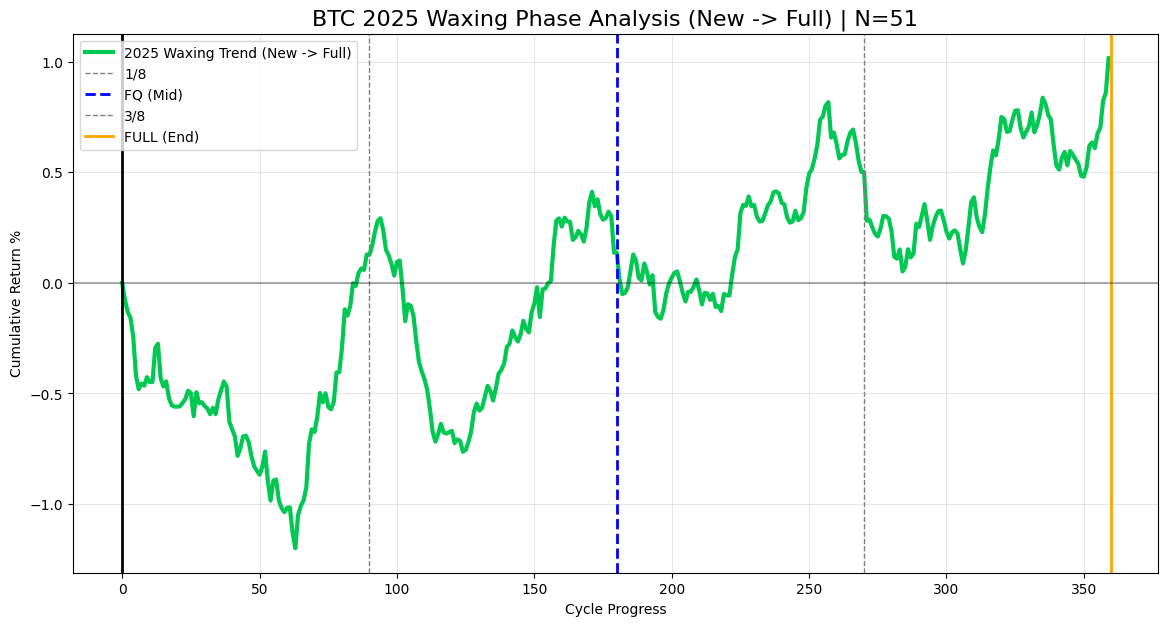


=== 2025 Waxing (渐盈月) 战术板 ===
1. New -> 1/8: 0.13%
2. 1/8 -> FQ : 0.01%
3. FQ -> 3/8 : 0.37%
4. 3/8 -> Full: 0.51%
------------------------------
💰 全程总收益 (New -> Full): 1.02%

=== 🤖 2025 市场特征解读 ===
✅ 整体趋势：Waxing 阶段是赚钱的（上涨）。
🔥 最强爆发段: 3/8->Full (收益 0.51%)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import io

# ==========================================
# 1. 加载 Waxing (新月->满月) 数据
# ==========================================

# ⚠️ 保持你的文件路径不变
file_path = '/content/BTC_1h_2021-11-01T17_26_to_2025-12-11T17_26_WAXING.csv'

try:
    print(f"正在读取文件: {file_path} ...")
    df = pd.read_csv(file_path)

    # 时间格式处理
    if 'Timestamp' in df.columns:
        df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
    else:
        df['Date'] = pd.to_datetime(df['Date'])

    df = df.sort_values('Date').drop_duplicates(subset=['Date'], keep='last').reset_index(drop=True)

    # 清洗 KeyMarker
    df['KeyMarker'] = df['KeyMarker'].fillna('').astype(str).str.strip().str.upper()
    name_map = {'NEW MOON': 'NEW', 'FULL MOON': 'FULL', 'FIRST QUARTER': 'FQ', '1ST QUARTER': 'FQ'}
    df['KeyMarker'] = df['KeyMarker'].replace(name_map)

    print(f"数据加载成功: {len(df)} 行")
    print(f"检测到的标记: {df[df['KeyMarker'] != '']['KeyMarker'].unique()}")

except Exception as e:
    print(f"❌ 读取错误: {e}")
    df = pd.DataFrame()

# ==========================================
# 2. 核心算法：四段式拟合 (智能容错版)
# ==========================================

if not df.empty:
    # 提取关键索引
    new_idxs = df[df['KeyMarker'] == 'NEW'].index.tolist()
    marker_18_idxs = df[df['KeyMarker'] == '1/8'].index.tolist()
    marker_fq_idxs = df[df['KeyMarker'] == 'FQ'].index.tolist()
    marker_38_idxs = df[df['KeyMarker'] == '3/8'].index.tolist()
    # 尝试提取 FULL，如果没找到也没关系
    full_idxs = df[df['KeyMarker'] == 'FULL'].index.tolist()

    seg1_curves = [] # New -> 1/8
    seg2_curves = [] # 1/8 -> FQ
    seg3_curves = [] # FQ -> 3/8
    seg4_curves = [] # 3/8 -> End(Full)

    # 绘图长度
    L1, L2, L3, L4 = 90, 90, 90, 90
    valid_cycles = 0

    print("正在进行分段拟合 (容错模式)...")

    for i in range(len(new_idxs)):
        start = new_idxs[i]

        # 确定本周期的绝对终点：下一个 New 的前一行，或者数据末尾
        if i < len(new_idxs) - 1:
            cycle_limit = new_idxs[i+1]
        else:
            cycle_limit = len(df)

        # 在 [start, cycle_limit] 范围内找中间点
        c_18 = [x for x in marker_18_idxs if x > start and x < cycle_limit]
        c_fq = [x for x in marker_fq_idxs if x > start and x < cycle_limit]
        c_38 = [x for x in marker_38_idxs if x > start and x < cycle_limit]

        # 容错：必须找到 1/8, FQ, 3/8 才能保证结构准确
        if not c_18 or not c_fq or not c_38:
            continue

        idx_18 = c_18[0]
        idx_fq = c_fq[0]
        idx_38 = c_38[0]

        # 确定终点：如果有 FULL 标记就用 FULL，没有就用 cycle_limit - 1
        c_full = [x for x in full_idxs if x > idx_38 and x < cycle_limit]

        if c_full:
            end = c_full[0]
        else:
            # 如果没有 FULL 标记，我们假设 3/8 之后的这一段数据的终点就是满月前夕
            end = cycle_limit - 1
            # 简单校验：3/8 到终点不能太短，也不能太长
            if end - idx_38 < 10: continue

        # 顺序校验
        if not (start < idx_18 < idx_fq < idx_38 < end):
            continue

        valid_cycles += 1

        # === 提取四段数据 ===
        # 归一化函数
        def normalize_segment(prices, length_out):
            if len(prices) < 2: return np.zeros(length_out)
            seg_ret = (prices - prices[0]) / prices[0] * 100
            x_old = np.linspace(0, 1, len(seg_ret))
            x_new = np.linspace(0, 1, length_out)
            return interp1d(x_old, seg_ret, kind='linear')(x_new)

        s1 = df.iloc[start : idx_18+1]['Close'].values
        s2 = df.iloc[idx_18 : idx_fq+1]['Close'].values
        s3 = df.iloc[idx_fq : idx_38+1]['Close'].values
        s4 = df.iloc[idx_38 : end+1]['Close'].values

        seg1_curves.append(normalize_segment(s1, L1))
        seg2_curves.append(normalize_segment(s2, L2))
        seg3_curves.append(normalize_segment(s3, L3))
        seg4_curves.append(normalize_segment(s4, L4))

    print(f"成功提取 {valid_cycles} 个 Waxing 周期")

    if valid_cycles > 0:
        # ==========================================
        # 3. 绘图与分析
        # ==========================================
        avg_s1 = np.mean(seg1_curves, axis=0)
        avg_s2 = np.mean(seg2_curves, axis=0)
        avg_s3 = np.mean(seg3_curves, axis=0)
        avg_s4 = np.mean(seg4_curves, axis=0)

        final_curve = []
        final_curve.extend(avg_s1)
        final_curve.extend(avg_s2 + final_curve[-1])
        final_curve.extend(avg_s3 + final_curve[-1])
        final_curve.extend(avg_s4 + final_curve[-1])

        plt.figure(figsize=(14, 7))
        x_axis = range(len(final_curve))

        plt.plot(x_axis, final_curve, color='#00C853', linewidth=3, label='2025 Waxing Trend (New -> Full)')

        # 绘制竖线
        plt.axvline(x=0, color='black', linestyle='-', linewidth=2)
        plt.axvline(x=L1, color='gray', linestyle='--', linewidth=1, label='1/8')
        plt.axvline(x=L1+L2, color='blue', linestyle='--', linewidth=2, label='FQ (Mid)')
        plt.axvline(x=L1+L2+L3, color='gray', linestyle='--', linewidth=1, label='3/8')
        plt.axvline(x=L1+L2+L3+L4, color='orange', linestyle='-', linewidth=2, label='FULL (End)')

        plt.axhline(0, color='black', alpha=0.3)

        # 计算各阶段收益
        r_total = final_curve[-1]
        r_s1 = avg_s1[-1]
        r_s2 = avg_s2[-1]
        r_s3 = avg_s3[-1]
        r_s4 = avg_s4[-1]

        plt.title(f'BTC 2025 Waxing Phase Analysis (New -> Full) | N={valid_cycles}', fontsize=16)
        plt.xlabel('Cycle Progress')
        plt.ylabel('Cumulative Return %')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        print("\n=== 2025 Waxing (渐盈月) 战术板 ===")
        print(f"1. New -> 1/8: {r_s1:.2f}%")
        print(f"2. 1/8 -> FQ : {r_s2:.2f}%")
        print(f"3. FQ -> 3/8 : {r_s3:.2f}%")
        print(f"4. 3/8 -> Full: {r_s4:.2f}%")
        print("-" * 30)
        print(f"💰 全程总收益 (New -> Full): {r_total:.2f}%")

        print("\n=== 🤖 2025 市场特征解读 ===")
        if r_total > 0:
            print("✅ 整体趋势：Waxing 阶段是赚钱的（上涨）。")
        else:
            print("❌ 整体趋势：Waxing 阶段是亏钱的（下跌）。")

        # 寻找最佳买点
        best_section = max([(r_s1, "New->1/8"), (r_s2, "1/8->FQ"), (r_s3, "FQ->3/8"), (r_s4, "3/8->Full")], key=lambda x:x[0])
        print(f"🔥 最强爆发段: {best_section[1]} (收益 {best_section[0]:.2f}%)")

        if r_s4 < 0:
            print("⚠️ 风险提示：满月前夕 (3/8->Full) 出现下跌，一定要在 3/8 止盈！")

    else:
        print("❌ 依然未提取到周期，可能是数据太少或标记严重缺失。")

正在读取文件... /content/BTC_1h_2022-01-12T17_47_to_2025-12-11T17_47.csv
数据加载成功: 34295 行
检测到的标记: ['3/8' 'FULL' '5/8' 'LQ' '7/8' 'NEW' '1/8' 'FQ']
正在分析 47 个完整月相周期...


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24358 (\N{CJK UNIFIED IDEOGRAPH-5F26}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28385 (\N{CJK UNIFIED IDEOGRAPH-6EE1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20080 (\N{CJK UNIFIED IDEOGRAPH-4E70}) missing from font(s) DejaVu Sans.
  fig.canvas

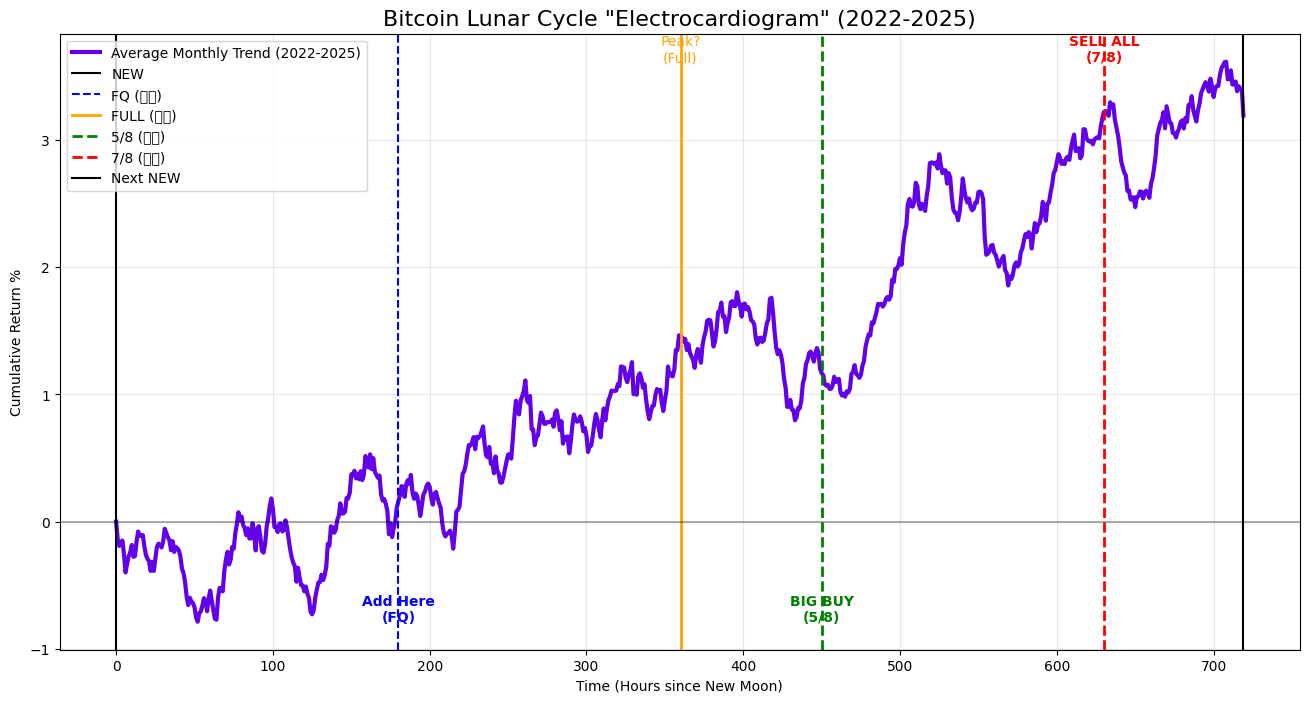


=== 🌕 月相操盘口诀验证报告 (2022-2025) ===
阶段名称                 | 平均收益%      | 胜率%        | 操作建议
-----------------------------------------------------------------
1. New->FQ (上半场)     | +0.39      | 48.9       | ✅ 轻仓做多
2. FQ->Full (冲刺)     | +1.01      | 66.0       | 🔥 重点做多
3. Full->5/8 (回调)    | -0.59      | 46.8       | 观望/做空
4. 5/8->7/8 (主升浪)    | +1.80      | 51.1       | 🔥 重点做多
5. 7/8->New (鱼尾)     | +0.29      | 55.3       | ✅ 轻仓做多

💰 [终极策略] 5/8(MA24过滤)->7/8 资金最终净值: 191.64 (初始100)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import io

# ==========================================
# 1. 加载数据 (2022-2025 全数据)
# ==========================================

# ⚠️⚠️⚠️ 请修改为你刚刚上传的全数据文件名 ⚠️⚠️⚠️
file_path = '/content/BTC_1h_2022-01-12T17_47_to_2025-12-11T17_47.csv'
# 注意：如果不知道文件名，请在左侧文件栏右键点击文件选"Copy path"

try:
    print(f"正在读取文件... {file_path}")
    df = pd.read_csv(file_path)

    # 时间清洗
    if 'Timestamp' in df.columns:
        df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
    else:
        df['Date'] = pd.to_datetime(df['Date'])

    df = df.sort_values('Date').drop_duplicates(subset=['Date'], keep='last').reset_index(drop=True)

    # 标记清洗
    df['KeyMarker'] = df['KeyMarker'].fillna('').astype(str).str.strip().str.upper()
    name_map = {'NEW MOON': 'NEW', 'FULL MOON': 'FULL', 'FIRST QUARTER': 'FQ', '1ST QUARTER': 'FQ', 'LAST QUARTER': 'LQ'}
    df['KeyMarker'] = df['KeyMarker'].replace(name_map)

    # 计算 MA24 (用于 5/8 过滤)
    df['MA_24'] = df['Close'].rolling(window=24).mean()

    print(f"数据加载成功: {len(df)} 行")
    print(f"检测到的标记: {df[df['KeyMarker'] != '']['KeyMarker'].unique()}")

except Exception as e:
    print(f"❌ 读取错误: {e}")
    df = pd.DataFrame()

# ==========================================
# 2. 全周期拟合 (New -> New)
# ==========================================

if not df.empty:
    new_idxs = df[df['KeyMarker'] == 'NEW'].index.tolist()

    # 存储标准化后的曲线 (长度固定为 720小时，约30天)
    L_CYCLE = 720
    all_cycles = []

    # 统计分段收益
    segment_returns = {
        '1. New->FQ (上半场)': [],
        '2. FQ->Full (冲刺)': [],
        '3. Full->5/8 (回调)': [],
        '4. 5/8->7/8 (主升浪)': [],
        '5. 7/8->New (鱼尾)': []
    }

    print(f"正在分析 {len(new_idxs)-1} 个完整月相周期...")

    for i in range(len(new_idxs)-1):
        start = new_idxs[i]
        end = new_idxs[i+1]

        # === A. 绘图数据准备 ===
        prices = df.iloc[start:end]['Close'].values
        if len(prices) < 300: continue # 跳过数据缺失的周期

        # 归一化 (以 New Moon 开盘价为基准)
        norm_p = (prices - prices[0]) / prices[0] * 100
        # 时间插值
        x_old = np.linspace(0, 1, len(norm_p))
        x_new = np.linspace(0, 1, L_CYCLE)
        f = interp1d(x_old, norm_p, kind='linear')
        all_cycles.append(f(x_new))

        # === B. 关键区间收益统计 (用于验证口诀) ===
        # 在本周期内找关键点
        sub_df = df.iloc[start:end]

        try:
            idx_new = start
            idx_fq = sub_df[sub_df['KeyMarker'] == 'FQ'].index[0]
            idx_full = sub_df[sub_df['KeyMarker'] == 'FULL'].index[0]
            idx_58 = sub_df[sub_df['KeyMarker'] == '5/8'].index[0]
            idx_78 = sub_df[sub_df['KeyMarker'] == '7/8'].index[0]

            p_new = df.iloc[idx_new]['Open']
            p_fq = df.iloc[idx_fq]['Open']
            p_full = df.iloc[idx_full]['Open']
            p_58 = df.iloc[idx_58]['Open']
            p_78 = df.iloc[idx_78]['Open']
            p_end = df.iloc[end]['Open'] # 下一个 New

            segment_returns['1. New->FQ (上半场)'].append((p_fq - p_new)/p_new * 100)
            segment_returns['2. FQ->Full (冲刺)'].append((p_full - p_fq)/p_fq * 100)
            segment_returns['3. Full->5/8 (回调)'].append((p_58 - p_full)/p_full * 100)
            segment_returns['4. 5/8->7/8 (主升浪)'].append((p_78 - p_58)/p_58 * 100)
            segment_returns['5. 7/8->New (鱼尾)'].append((p_end - p_78)/p_78 * 100)

        except IndexError:
            continue # 某些周期标记不全，跳过统计

    # ==========================================
    # 3. 绘图：月相心电图
    # ==========================================
    if len(all_cycles) > 0:
        avg_curve = np.mean(all_cycles, axis=0)

        plt.figure(figsize=(16, 8))
        x_axis = range(L_CYCLE)

        # 绘制平均线
        plt.plot(x_axis, avg_curve, color='#6200EA', linewidth=3, label='Average Monthly Trend (2022-2025)')

        # 估算关键时间点 (近似位置)
        # New=0, FQ≈0.25, Full≈0.5, 5/8≈0.625, 7/8≈0.875
        plt.axvline(x=0, color='black', label='NEW')
        plt.axvline(x=L_CYCLE*0.25, color='blue', linestyle='--', label='FQ (上弦)')
        plt.axvline(x=L_CYCLE*0.5, color='orange', linestyle='-', linewidth=2, label='FULL (满月)')
        plt.axvline(x=L_CYCLE*0.625, color='green', linestyle='--', linewidth=2, label='5/8 (买点)')
        plt.axvline(x=L_CYCLE*0.875, color='red', linestyle='--', linewidth=2, label='7/8 (卖点)')
        plt.axvline(x=L_CYCLE-1, color='black', label='Next NEW')

        plt.axhline(0, color='black', alpha=0.3)
        plt.title('Bitcoin Lunar Cycle "Electrocardiogram" (2022-2025)', fontsize=16)
        plt.xlabel('Time (Hours since New Moon)')
        plt.ylabel('Cumulative Return %')
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)

        # 标注操作建议
        min_v = min(avg_curve)
        plt.text(L_CYCLE*0.25, min_v, 'Add Here\n(FQ)', ha='center', color='blue', fontweight='bold')
        plt.text(L_CYCLE*0.5, max(avg_curve), 'Peak?\n(Full)', ha='center', color='orange')
        plt.text(L_CYCLE*0.625, min_v, 'BIG BUY\n(5/8)', ha='center', color='green', fontweight='bold')
        plt.text(L_CYCLE*0.875, max(avg_curve), 'SELL ALL\n(7/8)', ha='center', color='red', fontweight='bold')

        plt.show()

        # ==========================================
        # 4. 统计报告输出
        # ==========================================
        print("\n=== 🌕 月相操盘口诀验证报告 (2022-2025) ===")
        print(f"{'阶段名称':<20} | {'平均收益%':<10} | {'胜率%':<10} | {'操作建议'}")
        print("-" * 65)

        for name, rets in segment_returns.items():
            avg_ret = np.mean(rets)
            win_rate = np.mean([r > 0 for r in rets]) * 100

            advice = "观望/做空"
            if avg_ret > 0.5: advice = "🔥 重点做多"
            elif avg_ret > 0: advice = "✅ 轻仓做多"

            print(f"{name:<20} | {avg_ret:<+10.2f} | {win_rate:<10.1f} | {advice}")

        # ==========================================
        # 5. 终极策略资金曲线 (MA24 Filter on 5/8)
        # ==========================================
        # 模拟：只做 "5/8 -> 7/8" 这一段最肥的，且带 MA24 过滤
        capital = 100
        capital_curve = [100]

        # 重新遍历计算策略
        for i in range(len(new_idxs)-1):
            start = new_idxs[i]
            end = new_idxs[i+1]
            sub = df.iloc[start:end]
            try:
                idx_58 = sub[sub['KeyMarker'] == '5/8'].index[0]
                idx_78 = sub[sub['KeyMarker'] == '7/8'].index[0]

                p_buy = df.iloc[idx_58]['Open']
                p_sell = df.iloc[idx_78]['Open']
                ma_val = df.iloc[idx_58]['MA_24']

                # 策略：价格 > MA24 才做，否则空仓
                if p_buy > ma_val:
                    ret = (p_sell - p_buy) / p_buy
                else:
                    ret = 0

                capital = capital * (1 + ret)
                capital_curve.append(capital)
            except:
                continue

        print(f"\n💰 [终极策略] 5/8(MA24过滤)->7/8 资金最终净值: {capital:.2f} (初始100)")

    else:
        print("❌ 数据不足或未提取到完整周期。")

正在读取文件... /content/BTC_1h_2022-01-12T17_47_to_2025-12-11T17_47.csv
数据加载成功: 34295 行
正在深度拆解 47 个月相周期...


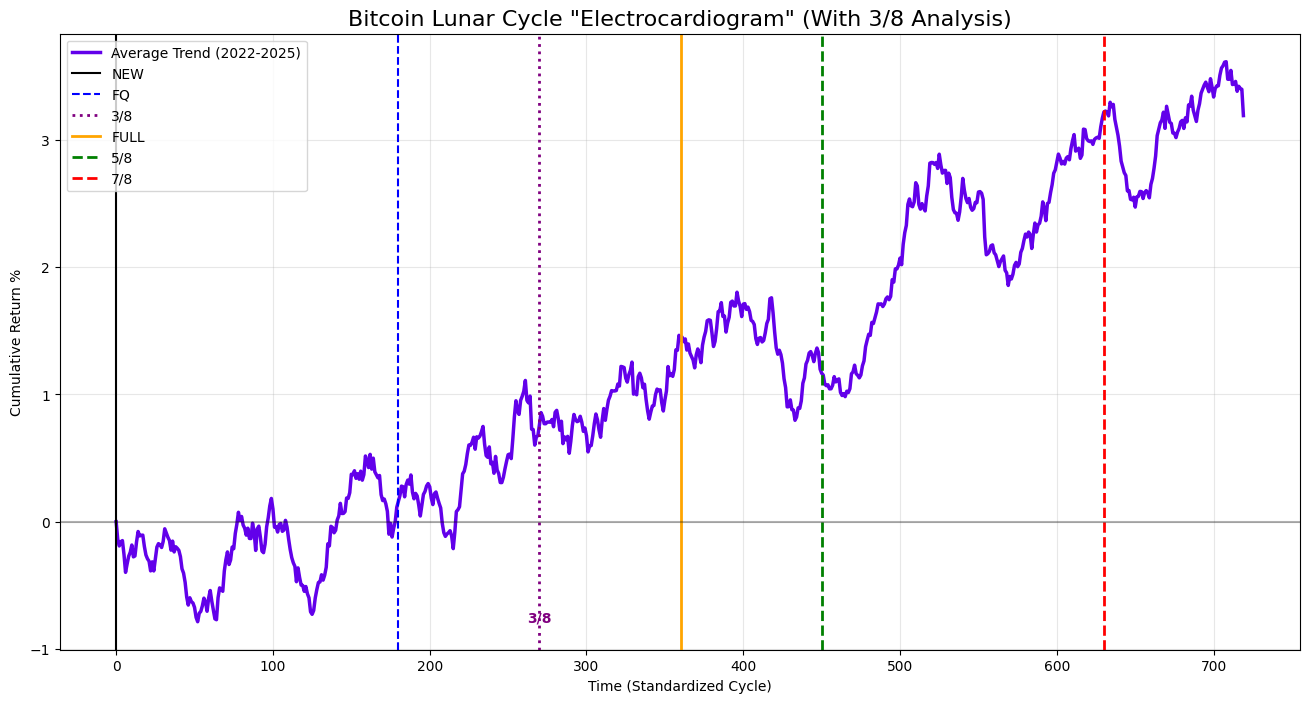


=== 🌕 6段式月相实战手册 (含3/8) ===
阶段名称                 | 平均收益%      | 胜率%        | 操作建议
-----------------------------------------------------------------
1. New -> FQ         | +0.39      | 48.9       | ✅ 持有/低吸
2. FQ -> 3/8         | +0.35      | 53.2       | ✅ 持有/低吸
3. 3/8 -> Full       | +0.72      | 59.6       | 🔥 强力做多
4. Full -> 5/8       | -0.59      | 46.8       | 🛑 止盈/做空
5. 5/8 -> 7/8        | +1.80      | 51.1       | 🔥 强力做多
6. 7/8 -> New        | +0.29      | 55.3       | ✅ 持有/低吸

=== 🔎 3/8 节点特别诊断 ===
📈 全程加速：FQ->3/8 (+0.35%)，3/8->Full (+0.72%)
👉 结论：3/8 是中继，拿住直到满月！


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import io

# ==========================================
# 1. 加载数据 (2022-2025 全数据)
# ==========================================

# ⚠️⚠️⚠️ 请确认文件名是否正确 ⚠️⚠️⚠️
file_path = '/content/BTC_1h_2022-01-12T17_47_to_2025-12-11T17_47.csv'

try:
    print(f"正在读取文件... {file_path}")
    df = pd.read_csv(file_path)

    if 'Timestamp' in df.columns:
        df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
    else:
        df['Date'] = pd.to_datetime(df['Date'])

    df = df.sort_values('Date').drop_duplicates(subset=['Date'], keep='last').reset_index(drop=True)

    # 标记清洗
    df['KeyMarker'] = df['KeyMarker'].fillna('').astype(str).str.strip().str.upper()
    name_map = {'NEW MOON': 'NEW', 'FULL MOON': 'FULL', 'FIRST QUARTER': 'FQ', '1ST QUARTER': 'FQ'}
    df['KeyMarker'] = df['KeyMarker'].replace(name_map)

    # 计算 MA24
    df['MA_24'] = df['Close'].rolling(window=24).mean()

    print(f"数据加载成功: {len(df)} 行")

except Exception as e:
    print(f"❌ 读取错误: {e}")
    df = pd.DataFrame()

# ==========================================
# 2. 全周期 6 段式拟合 (含 3/8)
# ==========================================

if not df.empty:
    new_idxs = df[df['KeyMarker'] == 'NEW'].index.tolist()

    # 标准化长度 (30天 * 24小时)
    L_CYCLE = 720
    all_cycles = []

    # 统计 6 个阶段的收益
    segment_returns = {
        '1. New -> FQ': [],
        '2. FQ -> 3/8': [],   # 新增
        '3. 3/8 -> Full': [], # 新增
        '4. Full -> 5/8': [],
        '5. 5/8 -> 7/8': [],
        '6. 7/8 -> New': []
    }

    print(f"正在深度拆解 {len(new_idxs)-1} 个月相周期...")

    for i in range(len(new_idxs)-1):
        start = new_idxs[i]
        end = new_idxs[i+1]

        # === A. 绘图数据准备 ===
        prices = df.iloc[start:end]['Close'].values
        if len(prices) < 300: continue

        norm_p = (prices - prices[0]) / prices[0] * 100
        x_old = np.linspace(0, 1, len(norm_p))
        x_new = np.linspace(0, 1, L_CYCLE)
        all_cycles.append(interp1d(x_old, norm_p, kind='linear')(x_new))

        # === B. 6段收益统计 ===
        sub_df = df.iloc[start:end]

        try:
            # 必须找到所有关键点
            idx_new = start
            idx_fq = sub_df[sub_df['KeyMarker'] == 'FQ'].index[0]
            idx_38 = sub_df[sub_df['KeyMarker'] == '3/8'].index[0] # 必须有 3/8
            idx_full = sub_df[sub_df['KeyMarker'] == 'FULL'].index[0]
            idx_58 = sub_df[sub_df['KeyMarker'] == '5/8'].index[0]
            idx_78 = sub_df[sub_df['KeyMarker'] == '7/8'].index[0]

            p_new = df.iloc[idx_new]['Open']
            p_fq = df.iloc[idx_fq]['Open']
            p_38 = df.iloc[idx_38]['Open']
            p_full = df.iloc[idx_full]['Open']
            p_58 = df.iloc[idx_58]['Open']
            p_78 = df.iloc[idx_78]['Open']
            p_end = df.iloc[end]['Open']

            # 记录各段收益
            segment_returns['1. New -> FQ'].append((p_fq - p_new)/p_new * 100)
            segment_returns['2. FQ -> 3/8'].append((p_38 - p_fq)/p_fq * 100)
            segment_returns['3. 3/8 -> Full'].append((p_full - p_38)/p_38 * 100)
            segment_returns['4. Full -> 5/8'].append((p_58 - p_full)/p_full * 100)
            segment_returns['5. 5/8 -> 7/8'].append((p_78 - p_58)/p_58 * 100)
            segment_returns['6. 7/8 -> New'].append((p_end - p_78)/p_78 * 100)

        except IndexError:
            continue

    # ==========================================
    # 3. 绘图：精细版月相心电图
    # ==========================================
    if len(all_cycles) > 0:
        avg_curve = np.mean(all_cycles, axis=0)

        plt.figure(figsize=(16, 8))
        x_axis = range(L_CYCLE)

        plt.plot(x_axis, avg_curve, color='#6200EA', linewidth=2.5, label='Average Trend (2022-2025)')

        # 绘制 6 个关键时间竖线 (近似位置)
        # New=0, FQ=0.25, 3/8=0.375, Full=0.5, 5/8=0.625, 7/8=0.875
        plt.axvline(x=0, color='black', label='NEW')
        plt.axvline(x=L_CYCLE*0.25, color='blue', linestyle='--', label='FQ')
        plt.axvline(x=L_CYCLE*0.375, color='purple', linestyle=':', linewidth=2, label='3/8')
        plt.axvline(x=L_CYCLE*0.5, color='orange', linestyle='-', linewidth=2, label='FULL')
        plt.axvline(x=L_CYCLE*0.625, color='green', linestyle='--', linewidth=2, label='5/8')
        plt.axvline(x=L_CYCLE*0.875, color='red', linestyle='--', linewidth=2, label='7/8')

        plt.axhline(0, color='black', alpha=0.3)
        plt.title('Bitcoin Lunar Cycle "Electrocardiogram" (With 3/8 Analysis)', fontsize=16)
        plt.xlabel('Time (Standardized Cycle)')
        plt.ylabel('Cumulative Return %')
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)

        # 标注
        min_v = min(avg_curve)
        max_v = max(avg_curve)
        plt.text(L_CYCLE*0.375, min_v, '3/8', ha='center', color='purple', fontweight='bold')

        plt.show()

        # ==========================================
        # 4. 六段式数据报告
        # ==========================================
        print("\n=== 🌕 6段式月相实战手册 (含3/8) ===")
        print(f"{'阶段名称':<20} | {'平均收益%':<10} | {'胜率%':<10} | {'操作建议'}")
        print("-" * 65)

        for name, rets in segment_returns.items():
            avg_ret = np.mean(rets)
            win_rate = np.mean([r > 0 for r in rets]) * 100

            advice = "⚪ 观望"
            if avg_ret > 0.6: advice = "🔥 强力做多"
            elif avg_ret > 0.2: advice = "✅ 持有/低吸"
            elif avg_ret < -0.2: advice = "🛑 止盈/做空"

            print(f"{name:<20} | {avg_ret:<+10.2f} | {win_rate:<10.1f} | {advice}")

        # 重点分析 3/8
        r_fq_38 = np.mean(segment_returns['2. FQ -> 3/8'])
        r_38_full = np.mean(segment_returns['3. 3/8 -> Full'])

        print("\n=== 🔎 3/8 节点特别诊断 ===")
        if r_fq_38 > 0 and r_38_full > 0:
            print(f"📈 全程加速：FQ->3/8 (+{r_fq_38:.2f}%)，3/8->Full (+{r_38_full:.2f}%)")
            print("👉 结论：3/8 是中继，拿住直到满月！")
        elif r_fq_38 > 0 and r_38_full < 0:
            print(f"📉 提前见顶：FQ->3/8 (+{r_fq_38:.2f}%)，但 3/8->Full 跌了 ({r_38_full:.2f}%)")
            print("👉 结论：满月跑太晚了！必须在 3/8 止盈！")
        else:
            print("👉 结论：震荡行情，看均线操作。")

    else:
        print("❌ 未提取到完整包含 3/8 的周期。")

正在读取文件... /content/BTC_1h_2022-01-12T17_47_to_2025-12-11T17_47.csv
数据加载成功: 34295 行
包含标记类型: ['3/8' 'FULL' '5/8' 'LQ' '7/8' 'NEW' '1/8' 'FQ']
正在深度拆解 47 个月相周期 (含 3/8 分析)...
成功提取 47 个包含所有关键点(含3/8)的周期


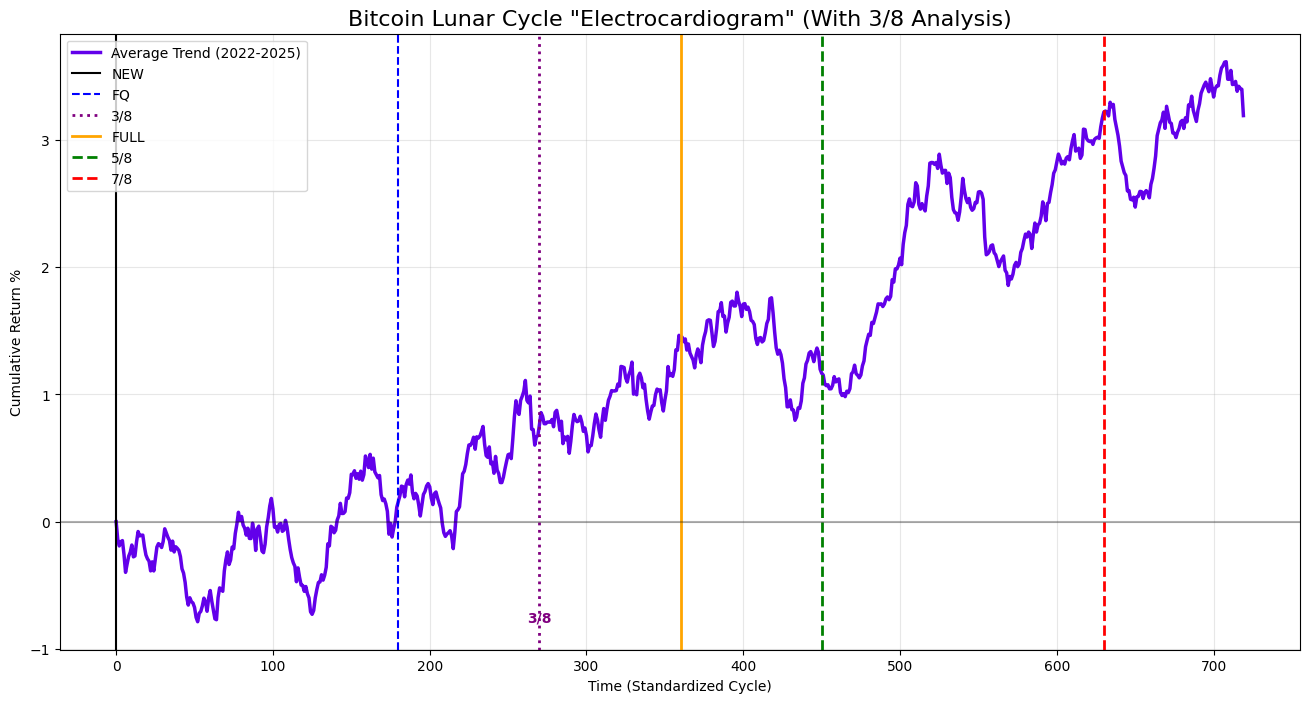


=== 🌕 6段式月相实战手册 (含3/8) ===
阶段名称                 | 平均收益%      | 胜率%        | 操作建议
-----------------------------------------------------------------
1. New -> FQ         | +0.39      | 48.9       | ✅ 持有/低吸
2. FQ -> 3/8         | +0.35      | 53.2       | ✅ 持有/低吸
3. 3/8 -> Full       | +0.72      | 59.6       | 🔥 强力做多
4. Full -> 5/8       | -0.59      | 46.8       | 🛑 止盈/做空
5. 5/8 -> 7/8        | +1.80      | 51.1       | 🔥 强力做多
6. 7/8 -> New        | +0.29      | 55.3       | ✅ 持有/低吸

=== 🔎 3/8 节点特别诊断 ===
📈 全程加速：FQ->3/8 (+0.35%)，3/8->Full (+0.72%)
👉 结论：3/8 是中继，拿住直到满月！


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import io

# ==========================================
# 1. 加载数据 (2022-2025 全数据)
# ==========================================

# ⚠️ 确保文件名和你上传的一致
file_path = '/content/BTC_1h_2022-01-12T17_47_to_2025-12-11T17_47.csv'

try:
    print(f"正在读取文件... {file_path}")
    df = pd.read_csv(file_path)

    if 'Timestamp' in df.columns:
        df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
    else:
        df['Date'] = pd.to_datetime(df['Date'])

    df = df.sort_values('Date').drop_duplicates(subset=['Date'], keep='last').reset_index(drop=True)

    # 标记清洗
    df['KeyMarker'] = df['KeyMarker'].fillna('').astype(str).str.strip().str.upper()
    name_map = {'NEW MOON': 'NEW', 'FULL MOON': 'FULL', 'FIRST QUARTER': 'FQ', '1ST QUARTER': 'FQ'}
    df['KeyMarker'] = df['KeyMarker'].replace(name_map)

    # 计算 MA24
    df['MA_24'] = df['Close'].rolling(window=24).mean()

    print(f"数据加载成功: {len(df)} 行")
    # 检查一下是否真的有 3/8
    print(f"包含标记类型: {df[df['KeyMarker'] != '']['KeyMarker'].unique()}")

except Exception as e:
    print(f"❌ 读取错误: {e}")
    df = pd.DataFrame()

# ==========================================
# 2. 全周期 6 段式拟合 (包含 3/8)
# ==========================================

if not df.empty:
    new_idxs = df[df['KeyMarker'] == 'NEW'].index.tolist()

    # 获取其他关键点索引
    fq_idxs = df[df['KeyMarker'] == 'FQ'].index.tolist()
    marker_38_idxs = df[df['KeyMarker'] == '3/8'].index.tolist() # ★ 新增
    full_idxs = df[df['KeyMarker'] == 'FULL'].index.tolist()
    marker_58_idxs = df[df['KeyMarker'] == '5/8'].index.tolist()
    marker_78_idxs = df[df['KeyMarker'] == '7/8'].index.tolist()

    # 标准化长度 (30天 * 24小时)
    L_CYCLE = 720
    all_cycles = []

    # ★ 修改：统计 6 个阶段的收益 (拆分了 FQ->Full)
    segment_returns = {
        '1. New -> FQ': [],
        '2. FQ -> 3/8': [],   # ★ 新增
        '3. 3/8 -> Full': [], # ★ 新增
        '4. Full -> 5/8': [],
        '5. 5/8 -> 7/8': [],
        '6. 7/8 -> New': []
    }

    print(f"正在深度拆解 {len(new_idxs)-1} 个月相周期 (含 3/8 分析)...")

    valid_cycles = 0

    for i in range(len(new_idxs)-1):
        start = new_idxs[i]
        end = new_idxs[i+1]

        # === A. 绘图数据准备 (全周期) ===
        prices = df.iloc[start:end]['Close'].values
        if len(prices) < 300: continue

        norm_p = (prices - prices[0]) / prices[0] * 100
        x_old = np.linspace(0, 1, len(norm_p))
        x_new = np.linspace(0, 1, L_CYCLE)
        all_cycles.append(interp1d(x_old, norm_p, kind='linear')(x_new))

        # === B. 6段收益统计 ===
        sub_df = df.iloc[start:end]

        try:
            # 必须找到所有关键点
            idx_new = start

            # 在当前周期范围内查找各个点
            # 逻辑：New < FQ < 3/8 < Full < 5/8 < 7/8

            # 查找 FQ
            c_fq = [x for x in fq_idxs if x > start and x < end]
            if not c_fq: continue
            idx_fq = c_fq[0]

            # 查找 3/8 (★ 必须在 FQ 之后)
            c_38 = [x for x in marker_38_idxs if x > idx_fq and x < end]
            if not c_38: continue
            idx_38 = c_38[0]

            # 查找 Full (★ 必须在 3/8 之后)
            c_full = [x for x in full_idxs if x > idx_38 and x < end]
            if not c_full: continue
            idx_full = c_full[0]

            # 查找 5/8 (★ 必须在 Full 之后)
            c_58 = [x for x in marker_58_idxs if x > idx_full and x < end]
            if not c_58: continue
            idx_58 = c_58[0]

            # 查找 7/8 (★ 必须在 5/8 之后)
            c_78 = [x for x in marker_78_idxs if x > idx_58 and x < end]
            if not c_78: continue
            idx_78 = c_78[0]

            valid_cycles += 1

            # 获取价格
            p_new = df.iloc[idx_new]['Open']
            p_fq = df.iloc[idx_fq]['Open']
            p_38 = df.iloc[idx_38]['Open']
            p_full = df.iloc[idx_full]['Open']
            p_58 = df.iloc[idx_58]['Open']
            p_78 = df.iloc[idx_78]['Open']
            p_end = df.iloc[end]['Open']

            # 记录各段收益
            segment_returns['1. New -> FQ'].append((p_fq - p_new)/p_new * 100)
            segment_returns['2. FQ -> 3/8'].append((p_38 - p_fq)/p_fq * 100) # ★
            segment_returns['3. 3/8 -> Full'].append((p_full - p_38)/p_38 * 100) # ★
            segment_returns['4. Full -> 5/8'].append((p_58 - p_full)/p_full * 100)
            segment_returns['5. 5/8 -> 7/8'].append((p_78 - p_58)/p_58 * 100)
            segment_returns['6. 7/8 -> New'].append((p_end - p_78)/p_78 * 100)

        except IndexError:
            continue

    print(f"成功提取 {valid_cycles} 个包含所有关键点(含3/8)的周期")

    # ==========================================
    # 3. 绘图：精细版月相心电图
    # ==========================================
    if len(all_cycles) > 0:
        avg_curve = np.mean(all_cycles, axis=0)

        plt.figure(figsize=(16, 8))
        x_axis = range(L_CYCLE)

        plt.plot(x_axis, avg_curve, color='#6200EA', linewidth=2.5, label='Average Trend (2022-2025)')

        # 绘制 6 个关键时间竖线 (近似位置比例)
        # New=0, FQ=0.25, 3/8=0.375, Full=0.5, 5/8=0.625, 7/8=0.875
        plt.axvline(x=0, color='black', label='NEW')
        plt.axvline(x=L_CYCLE*0.25, color='blue', linestyle='--', label='FQ')
        plt.axvline(x=L_CYCLE*0.375, color='purple', linestyle=':', linewidth=2, label='3/8') # ★
        plt.axvline(x=L_CYCLE*0.5, color='orange', linestyle='-', linewidth=2, label='FULL')
        plt.axvline(x=L_CYCLE*0.625, color='green', linestyle='--', linewidth=2, label='5/8')
        plt.axvline(x=L_CYCLE*0.875, color='red', linestyle='--', linewidth=2, label='7/8')

        plt.axhline(0, color='black', alpha=0.3)
        plt.title('Bitcoin Lunar Cycle "Electrocardiogram" (With 3/8 Analysis)', fontsize=16)
        plt.xlabel('Time (Standardized Cycle)')
        plt.ylabel('Cumulative Return %')
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)

        # 标注 3/8
        min_v = min(avg_curve)
        plt.text(L_CYCLE*0.375, min_v, '3/8', ha='center', color='purple', fontweight='bold')

        plt.show()

        # ==========================================
        # 4. 六段式数据报告
        # ==========================================
        print("\n=== 🌕 6段式月相实战手册 (含3/8) ===")
        print(f"{'阶段名称':<20} | {'平均收益%':<10} | {'胜率%':<10} | {'操作建议'}")
        print("-" * 65)

        for name, rets in segment_returns.items():
            if len(rets) == 0: continue
            avg_ret = np.mean(rets)
            win_rate = np.mean([r > 0 for r in rets]) * 100

            advice = "⚪ 观望"
            if avg_ret > 0.6: advice = "🔥 强力做多"
            elif avg_ret > 0.2: advice = "✅ 持有/低吸"
            elif avg_ret < -0.2: advice = "🛑 止盈/做空"

            print(f"{name:<20} | {avg_ret:<+10.2f} | {win_rate:<10.1f} | {advice}")

        # 重点分析 3/8
        if len(segment_returns['2. FQ -> 3/8']) > 0:
            r_fq_38 = np.mean(segment_returns['2. FQ -> 3/8'])
            r_38_full = np.mean(segment_returns['3. 3/8 -> Full'])

            print("\n=== 🔎 3/8 节点特别诊断 ===")
            if r_fq_38 > 0 and r_38_full > 0:
                print(f"📈 全程加速：FQ->3/8 (+{r_fq_38:.2f}%)，3/8->Full (+{r_38_full:.2f}%)")
                print("👉 结论：3/8 是中继，拿住直到满月！")
            elif r_fq_38 > 0 and r_38_full < 0:
                print(f"📉 提前见顶：FQ->3/8 (+{r_fq_38:.2f}%)，但 3/8->Full 跌了 ({r_38_full:.2f}%)")
                print("👉 结论：满月跑太晚了！必须在 3/8 止盈！")
            else:
                print("👉 结论：震荡行情，看均线操作。")

    else:
        print("❌ 未提取到完整包含 3/8 的周期。请检查 CSV 数据。")

数据加载完毕。
正在分析 48 个周期中的 1/8 节点效应...

成功提取 48 个包含 1/8 的完整样本
--------------------------------------------------
阶段 1: [New -> 1/8] (反弹修复期)
  💰 平均收益: -0.01%
  🎲 胜率    : 47.9%

阶段 2: [1/8 -> FQ] (震荡洗盘期)
  💰 平均收益: +0.47%
  🎲 胜率    : 52.1%
--------------------------------------------------
🤖 1/8 战术终极判定:
⚠️ 结论：前半月行情太差，建议空仓。


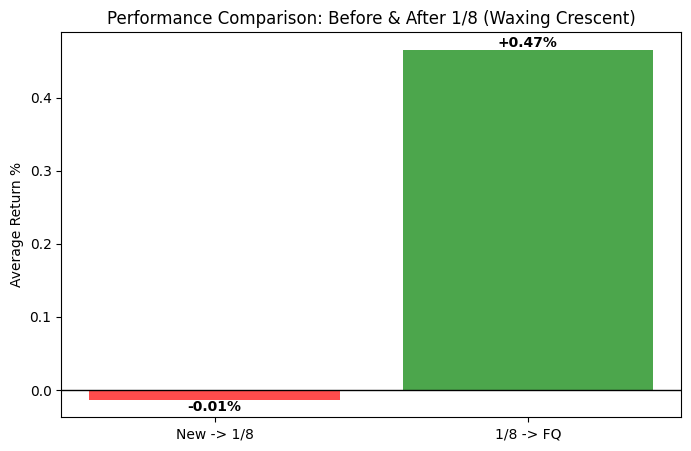

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 加载全周期数据
# ==========================================
file_path = '/content/BTC_1h_2022-01-12T17_47_to_2025-12-11T17_47.csv'

try:
    df = pd.read_csv(file_path)
    if 'Timestamp' in df.columns:
        df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
    else:
        df['Date'] = pd.to_datetime(df['Date'])

    df = df.sort_values('Date').drop_duplicates(subset=['Date'], keep='last').reset_index(drop=True)

    # 清洗标记
    df['KeyMarker'] = df['KeyMarker'].fillna('').astype(str).str.strip().str.upper()
    name_map = {'NEW MOON': 'NEW', 'FULL MOON': 'FULL', 'FIRST QUARTER': 'FQ', '1ST QUARTER': 'FQ'}
    df['KeyMarker'] = df['KeyMarker'].replace(name_map)

    print(f"数据加载完毕。")

except Exception as e:
    print(f"❌ 读取错误: {e}")
    df = pd.DataFrame()

# ==========================================
# 2. 1/8 节点专项测试
# ==========================================
# 目标：对比 (New -> 1/8) 和 (1/8 -> FQ) 的收益和胜率

if not df.empty:
    new_idxs = df[df['KeyMarker'] == 'NEW'].index.tolist()
    marker_18_idxs = df[df['KeyMarker'] == '1/8'].index.tolist()
    fq_idxs = df[df['KeyMarker'] == 'FQ'].index.tolist()

    phase1_stats = [] # New -> 1/8
    phase2_stats = [] # 1/8 -> FQ

    print(f"正在分析 {len(new_idxs)} 个周期中的 1/8 节点效应...")

    valid_count = 0

    for i in range(len(new_idxs)):
        start = new_idxs[i]
        next_limit = new_idxs[i+1] if i < len(new_idxs)-1 else len(df)

        # 在本周期内找 1/8 和 FQ
        c_18 = [x for x in marker_18_idxs if x > start and x < next_limit]
        c_fq = [x for x in fq_idxs if x > start and x < next_limit]

        # 必须两个都存在且顺序正确
        if not c_18 or not c_fq:
            continue

        idx_18 = c_18[0]
        idx_fq = c_fq[0]

        if idx_18 > idx_fq: # 顺序错误保护
            continue

        valid_count += 1

        # 获取价格
        p_new = df.iloc[start]['Open']
        p_18 = df.iloc[idx_18]['Open']
        p_fq = df.iloc[idx_fq]['Open']

        # 计算收益
        r1 = (p_18 - p_new) / p_new * 100
        r2 = (p_fq - p_18) / p_18 * 100

        phase1_stats.append(r1)
        phase2_stats.append(r2)

    # ==========================================
    # 3. 统计结果输出
    # ==========================================
    print(f"\n成功提取 {valid_count} 个包含 1/8 的完整样本")
    print("-" * 50)

    avg_p1 = np.mean(phase1_stats)
    win_p1 = np.mean([r > 0 for r in phase1_stats]) * 100

    avg_p2 = np.mean(phase2_stats)
    win_p2 = np.mean([r > 0 for r in phase2_stats]) * 100

    print(f"阶段 1: [New -> 1/8] (反弹修复期)")
    print(f"  💰 平均收益: {avg_p1:+.2f}%")
    print(f"  🎲 胜率    : {win_p1:.1f}%")

    print(f"\n阶段 2: [1/8 -> FQ] (震荡洗盘期)")
    print(f"  💰 平均收益: {avg_p2:+.2f}%")
    print(f"  🎲 胜率    : {win_p2:.1f}%")

    print("-" * 50)
    print("🤖 1/8 战术终极判定:")

    if avg_p1 > 0 and avg_p2 <= 0:
        print("✅ 结论：1/8 是短线止盈点！新月买入后，在 1/8 必须跑，后面会跌。")
    elif avg_p1 > 0 and avg_p2 > 0:
        if avg_p1 > avg_p2 * 2:
             print("✅ 结论：1/8 是短线高点。虽然后面也涨，但肉最肥的一段在 1/8 结束。建议减仓。")
        else:
             print("🚀 结论：1/8 是上涨中继。不要下车，一直拿到 FQ 甚至 Full。")
    else:
        print("⚠️ 结论：前半月行情太差，建议空仓。")

    # 画图对比
    labels = ['New -> 1/8', '1/8 -> FQ']
    values = [avg_p1, avg_p2]
    colors = ['green' if v > 0 else 'red' for v in values]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, values, color=colors, alpha=0.7)
    plt.axhline(0, color='black', linewidth=1)
    plt.ylabel('Average Return %')
    plt.title('Performance Comparison: Before & After 1/8 (Waxing Crescent)')

    # 在柱子上标数值
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:+.2f}%", ha='center', va='bottom' if yval>0 else 'top', fontweight='bold')

    plt.show()

else:
    print("数据为空，请检查文件路径。")

数据加载完毕。开始微观测试...

=== FQ (上弦月) -> Full 进场优化分析 ===
延迟(小时)     | 平均收益%      | 胜率%        | 踏空率%       | 性价比评分
-----------------------------------------------------------------
T + 0      | 1.01       | 66.7       | 0.0        | 1.01
T + 4      | 1.34       | 66.7       | 0.0        | 1.34
T + 8      | 1.23       | 66.7       | 0.0        | 1.23
T + 12     | 1.14       | 62.5       | 0.0        | 1.14
T + 18     | 1.56       | 62.5       | 0.0        | 1.56
T + 24     | 1.39       | 62.5       | 0.0        | 1.39
👉 最佳策略: 延迟 18 小时进场
💡 相比立即进场，每笔多赚: 0.55% (优化幅度)

=== 5/8 (黄金坑) -> 7/8 进场优化分析 ===
延迟(小时)     | 平均收益%      | 胜率%        | 踏空率%       | 性价比评分
-----------------------------------------------------------------
T + 0      | 1.61       | 50.0       | 0.0        | 1.61
T + 4      | 1.69       | 52.1       | 0.0        | 1.69
T + 8      | 1.83       | 54.2       | 0.0        | 1.83
T + 12     | 1.70       | 54.2       | 0.0        | 1.70
T + 18     | 1.77       | 52.1       | 0.0        | 

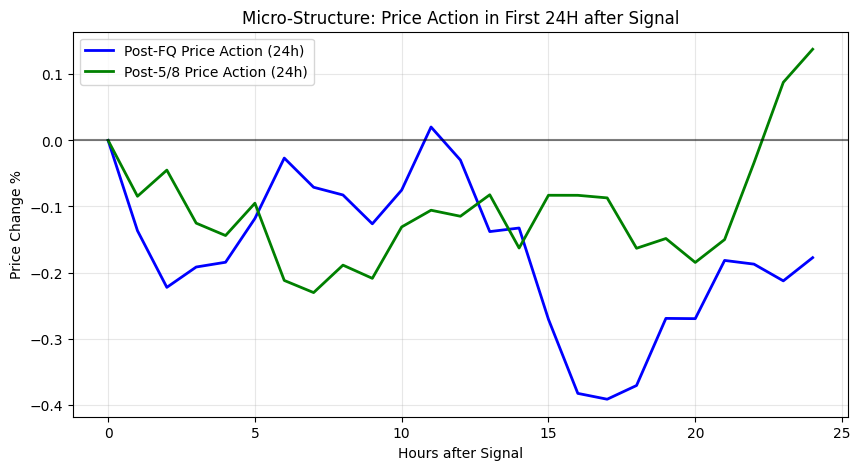

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 加载全周期数据
# ==========================================
file_path = '/content/BTC_1h_2022-01-12T17_47_to_2025-12-11T17_47.csv'

try:
    df = pd.read_csv(file_path)
    if 'Timestamp' in df.columns:
        df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
    else:
        df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').drop_duplicates(subset=['Date'], keep='last').reset_index(drop=True)

    # 标准化标记
    df['KeyMarker'] = df['KeyMarker'].fillna('').astype(str).str.strip().str.upper()
    name_map = {'NEW MOON': 'NEW', 'FULL MOON': 'FULL', 'FIRST QUARTER': 'FQ', '1ST QUARTER': 'FQ'}
    df['KeyMarker'] = df['KeyMarker'].replace(name_map)

    # 提取索引
    fq_idxs = df[df['KeyMarker'] == 'FQ'].index.tolist()
    m58_idxs = df[df['KeyMarker'] == '5/8'].index.tolist()
    full_idxs = df[df['KeyMarker'] == 'FULL'].index.tolist()
    m78_idxs = df[df['KeyMarker'] == '7/8'].index.tolist()

    print("数据加载完毕。开始微观测试...")

except Exception as e:
    print(f"读取错误: {e}")

# ==========================================
# 2. 定义测试函数
# ==========================================

def test_entry_delay(entry_name, entry_idxs, exit_marker, delay_hours_list):
    stats = {lag: [] for lag in delay_hours_list}

    for idx in entry_idxs:
        start_time = df.iloc[idx]['Date']

        # 寻找对应的离场点（必须在进场点之后）
        # 优化：在 entry_idx 之后找最近的 exit_marker
        future_data = df.iloc[idx:]
        exit_candidates = future_data[future_data['KeyMarker'] == exit_marker]

        if exit_candidates.empty:
            continue

        exit_idx = exit_candidates.index[0]
        price_exit = df.iloc[exit_idx]['Open'] # 离场价格

        # 遍历不同的延迟时间
        for lag in delay_hours_list:
            actual_entry_idx = idx + lag

            # 如果延迟后已经超过了离场点，就算踏空 (收益为0 或 记为无效)
            if actual_entry_idx >= exit_idx:
                stats[lag].append(None) # 标记为踏空
                continue

            price_entry = df.iloc[actual_entry_idx]['Open']

            # 计算收益
            ret = (price_exit - price_entry) / price_entry * 100
            stats[lag].append(ret)

    return stats

# ==========================================
# 3. 执行测试：FQ 和 5/8
# ==========================================

lags = [0, 4, 8, 12, 18, 24] # 测试延迟 0小时到24小时

# 测试 A: FQ (上弦) -> Full (满月)
fq_results = test_entry_delay("FQ", fq_idxs, "FULL", lags)

# 测试 B: 5/8 -> 7/8
m58_results = test_entry_delay("5/8", m58_idxs, "7/8", lags)

# ==========================================
# 4. 分析与输出
# ==========================================

def print_analysis(title, results_dict):
    print(f"\n=== {title} 进场优化分析 ===")
    print(f"{'延迟(小时)':<10} | {'平均收益%':<10} | {'胜率%':<10} | {'踏空率%':<10} | {'性价比评分'}")
    print("-" * 65)

    base_return = np.nanmean(results_dict[0])

    best_lag = 0
    best_score = -999

    for lag in lags:
        data = results_dict[lag]
        valid_data = [x for x in data if x is not None] # 排除踏空的

        if not valid_data: continue

        avg_ret = np.mean(valid_data)
        win_rate = np.mean([x > 0 for x in valid_data]) * 100
        miss_rate = (data.count(None) / len(data)) * 100

        # 简单评分 = 收益 * (1 - 踏空率)
        score = avg_ret * (1 - miss_rate/100)

        if score > best_score:
            best_score = score
            best_lag = lag

        print(f"T + {lag:<6} | {avg_ret:<10.2f} | {win_rate:<10.1f} | {miss_rate:<10.1f} | {score:.2f}")

    print(f"👉 最佳策略: 延迟 {best_lag} 小时进场")
    if best_lag > 0:
        diff = np.nanmean(results_dict[best_lag]) - base_return
        print(f"💡 相比立即进场，每笔多赚: {diff:.2f}% (优化幅度)")
    else:
        print("💡 立即进场最好，不要等待。")

print_analysis("FQ (上弦月) -> Full", fq_results)
print_analysis("5/8 (黄金坑) -> 7/8", m58_results)

# ==========================================
# 5. 可视化对比 (前12小时的价格平均路径)
# ==========================================
# 我们截取 FQ 和 5/8 之后 24小时内的平均走势，看看是不是真的先跌后涨

def plot_micro_structure(idxs, label, color):
    curves = []
    for idx in idxs:
        if idx + 24 < len(df):
            # 归一化前24小时走势
            p = df.iloc[idx : idx+25]['Close'].values
            norm_p = (p - p[0]) / p[0] * 100
            curves.append(norm_p)

    if curves:
        avg_curve = np.mean(curves, axis=0)
        plt.plot(range(25), avg_curve, label=label, color=color, linewidth=2)

plt.figure(figsize=(10, 5))
plot_micro_structure(fq_idxs, 'Post-FQ Price Action (24h)', 'blue')
plot_micro_structure(m58_idxs, 'Post-5/8 Price Action (24h)', 'green')

plt.axhline(0, color='black', alpha=0.5)
plt.title('Micro-Structure: Price Action in First 24H after Signal')
plt.xlabel('Hours after Signal')
plt.ylabel('Price Change %')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

数据加载完毕。检测到 49 个 3/8 标记。

正在分析 3/8 -> Full 的最后冲刺段...

=== 3/8 (盈凸月) -> Full (满月) 战术分析 ===
延迟(小时)     | 平均收益%      | 胜率%        | 性价比评分
-----------------------------------------------------------------
T + 0      | 0.72       | 59.2       | 0.42
T + 4      | 0.97       | 65.3       | 0.63
T + 8      | 0.84       | 65.3       | 0.55
T + 12     | 1.05       | 63.3       | 0.67
T + 18     | 0.95       | 67.3       | 0.64
T + 24     | 0.88       | 65.3       | 0.58
-----------------------------------------------------------------


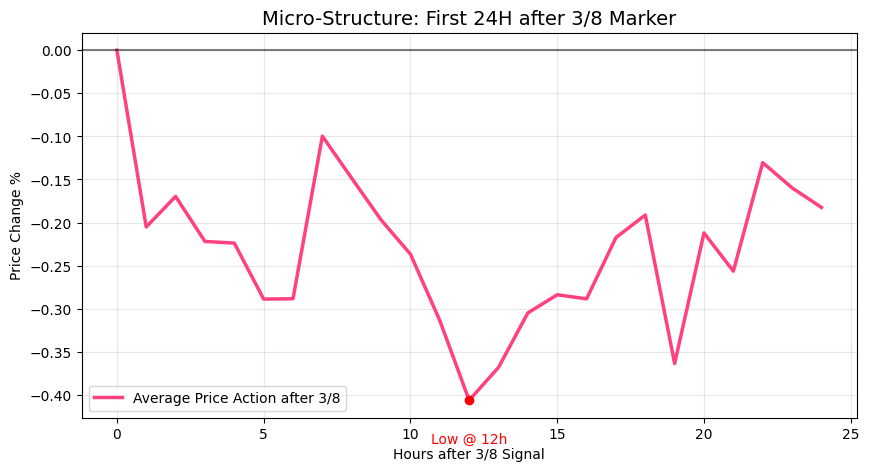

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 加载全周期数据
# ==========================================
file_path = '/content/BTC_1h_2022-01-12T17_47_to_2025-12-11T17_47.csv'

try:
    df = pd.read_csv(file_path)
    if 'Timestamp' in df.columns:
        df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
    else:
        df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').drop_duplicates(subset=['Date'], keep='last').reset_index(drop=True)

    # 标准化标记
    df['KeyMarker'] = df['KeyMarker'].fillna('').astype(str).str.strip().str.upper()
    name_map = {'NEW MOON': 'NEW', 'FULL MOON': 'FULL', 'FIRST QUARTER': 'FQ', '1ST QUARTER': 'FQ'}
    df['KeyMarker'] = df['KeyMarker'].replace(name_map)

    # 提取索引
    m38_idxs = df[df['KeyMarker'] == '3/8'].index.tolist()
    full_idxs = df[df['KeyMarker'] == 'FULL'].index.tolist()

    print(f"数据加载完毕。检测到 {len(m38_idxs)} 个 3/8 标记。")

except Exception as e:
    print(f"读取错误: {e}")

# ==========================================
# 2. 3/8 进场/离场 压力测试
# ==========================================

lags = [0, 4, 8, 12, 18, 24]
stats = {lag: [] for lag in lags}
micro_curves = []

print("\n正在分析 3/8 -> Full 的最后冲刺段...")

for idx in m38_idxs:
    # 找到之后最近的 Full Moon
    future_data = df.iloc[idx:]
    exit_candidates = future_data[future_data['KeyMarker'] == 'FULL']

    if exit_candidates.empty:
        continue

    exit_idx = exit_candidates.index[0]
    price_exit = df.iloc[exit_idx]['Open'] # 满月时刻的价格

    # --- A. 微观结构数据收集 (前24小时) ---
    if idx + 24 < len(df):
        p_micro = df.iloc[idx : idx+25]['Close'].values
        norm_p = (p_micro - p_micro[0]) / p_micro[0] * 100
        micro_curves.append(norm_p)

    # --- B. 延迟进场测试 ---
    for lag in lags:
        actual_entry_idx = idx + lag
        if actual_entry_idx >= exit_idx:
            stats[lag].append(None)
            continue

        price_entry = df.iloc[actual_entry_idx]['Open']
        ret = (price_exit - price_entry) / price_entry * 100
        stats[lag].append(ret)

# ==========================================
# 3. 输出统计结果
# ==========================================

print(f"\n=== 3/8 (盈凸月) -> Full (满月) 战术分析 ===")
print(f"{'延迟(小时)':<10} | {'平均收益%':<10} | {'胜率%':<10} | {'性价比评分'}")
print("-" * 65)

base_return = 0
for lag in lags:
    data = [x for x in stats[lag] if x is not None]
    if not data: continue

    avg_ret = np.mean(data)
    if lag == 0: base_return = avg_ret

    win_rate = np.mean([x > 0 for x in data]) * 100
    score = avg_ret * (win_rate / 100) # 简单评分

    print(f"T + {lag:<6} | {avg_ret:<10.2f} | {win_rate:<10.1f} | {score:.2f}")

print("-" * 65)

# ==========================================
# 4. 可视化 3/8 后的微观走势
# ==========================================
if micro_curves:
    avg_micro = np.mean(micro_curves, axis=0)

    plt.figure(figsize=(10, 5))
    plt.plot(range(25), avg_micro, color='#FF4081', linewidth=2.5, label='Average Price Action after 3/8')
    plt.axhline(0, color='black', alpha=0.5)

    # 标注最低点
    min_idx = np.argmin(avg_micro)
    plt.scatter(min_idx, avg_micro[min_idx], color='red', zorder=5)
    plt.text(min_idx, avg_micro[min_idx]-0.05, f'Low @ {min_idx}h', ha='center', color='red')

    plt.title('Micro-Structure: First 24H after 3/8 Marker', fontsize=14)
    plt.xlabel('Hours after 3/8 Signal')
    plt.ylabel('Price Change %')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

数据加载完毕。行数: 34295
成功拆解 48 个包含 3/8 的完整 Waxing 周期

=== 3/8 (盈凸月) 关键拆解报告 ===
阶段                   | 平均收益%      | 胜率%        | 战术价值
-----------------------------------------------------------------
1. 磨底期 (New -> FQ)   | +0.37      | 47.9       | ✅ 稳健区
2. 爬坡期 (FQ -> 3/8)   | +0.32      | 52.1       | ✅ 稳健区
3. 冲刺期 (3/8 -> Full) | +0.75      | 60.4       | 🔥 核心利润区
-----------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24358 (\N{CJK UNIFIED IDEOGRAPH-5F26}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30408 (\N{CJK UNIFIED IDEOGRAPH-76C8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20984 (\N{CJK UNIFIED IDEOGRAPH-51F8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28385 (\N{CJK UNIFIED IDEOGRAPH-6EE1}) missing from font(s) DejaVu Sans.
  fig.canvas

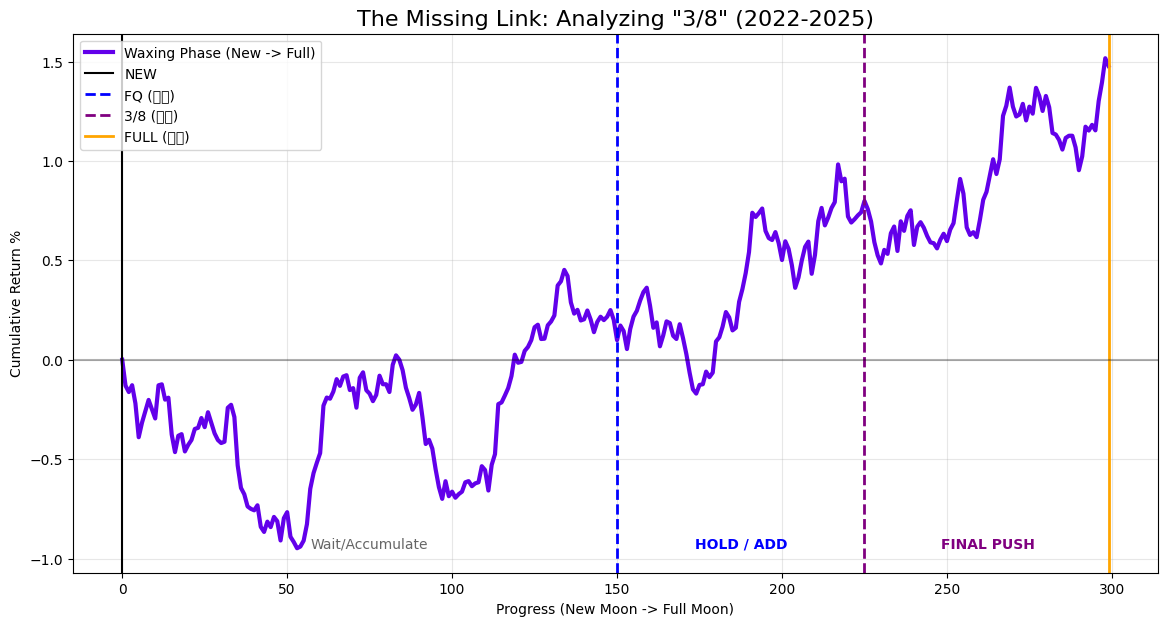


=== 💡 3/8 节点操作指南 ===
🚀 加速上涨：3/8 之后涨得比之前还猛！
👉 操作：FQ 买入后，在 3/8 处不要下车，甚至可以加仓，直到满月前一刻止盈。


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# ==========================================
# 1. 加载 2022-2025 全周期数据
# ==========================================
file_path = '/content/BTC_1h_2022-01-12T17_47_to_2025-12-11T17_47.csv'

try:
    df = pd.read_csv(file_path)
    if 'Timestamp' in df.columns:
        df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
    else:
        df['Date'] = pd.to_datetime(df['Date'])

    df = df.sort_values('Date').drop_duplicates(subset=['Date'], keep='last').reset_index(drop=True)

    # 清洗标记
    df['KeyMarker'] = df['KeyMarker'].fillna('').astype(str).str.strip().str.upper()
    name_map = {'NEW MOON': 'NEW', 'FULL MOON': 'FULL', 'FIRST QUARTER': 'FQ', '1ST QUARTER': 'FQ'}
    df['KeyMarker'] = df['KeyMarker'].replace(name_map)

    print(f"数据加载完毕。行数: {len(df)}")

except Exception as e:
    print(f"❌ 错误: {e}")

# ==========================================
# 2. 针对 Waxing 阶段的三段式拆解
# ==========================================
# 目标：New -> FQ -> 3/8 -> Full

new_idxs = df[df['KeyMarker'] == 'NEW'].index.tolist()
fq_idxs = df[df['KeyMarker'] == 'FQ'].index.tolist()
m38_idxs = df[df['KeyMarker'] == '3/8'].index.tolist()
full_idxs = df[df['KeyMarker'] == 'FULL'].index.tolist()

segment_stats = {
    '1. 磨底期 (New -> FQ)': [],
    '2. 爬坡期 (FQ -> 3/8)': [],
    '3. 冲刺期 (3/8 -> Full)': []
}

seg_curves = [] # 用于画图
L_TOTAL = 300 # 标准化长度

valid_cycles = 0

for i in range(len(new_idxs)):
    start = new_idxs[i]
    # 找下一个 New 防止跨周期
    next_new_limit = new_idxs[i+1] if i < len(new_idxs)-1 else len(df)

    # 在本周期内找点
    c_fq = [x for x in fq_idxs if x > start and x < next_new_limit]
    c_38 = [x for x in m38_idxs if x > start and x < next_new_limit]
    c_full = [x for x in full_idxs if x > start and x < next_new_limit]

    # 必须全部找到才算完整
    if not c_fq or not c_38 or not c_full:
        continue

    idx_fq = c_fq[0]
    idx_38 = c_38[0]
    idx_full = c_full[0]

    # 顺序校验: New < FQ < 3/8 < Full
    if not (start < idx_fq < idx_38 < idx_full):
        continue

    valid_cycles += 1

    # === A. 收益统计 ===
    p_new = df.iloc[start]['Open']
    p_fq = df.iloc[idx_fq]['Open']
    p_38 = df.iloc[idx_38]['Open']
    p_full = df.iloc[idx_full]['Open']

    segment_stats['1. 磨底期 (New -> FQ)'].append((p_fq - p_new) / p_new * 100)
    segment_stats['2. 爬坡期 (FQ -> 3/8)'].append((p_38 - p_fq) / p_fq * 100)
    segment_stats['3. 冲刺期 (3/8 -> Full)'].append((p_full - p_38) / p_38 * 100)

    # === B. 曲线拟合 (New -> Full) ===
    prices = df.iloc[start : idx_full+1]['Close'].values
    norm_p = (prices - prices[0]) / prices[0] * 100
    x_old = np.linspace(0, 1, len(norm_p))
    x_new = np.linspace(0, 1, L_TOTAL)
    seg_curves.append(interp1d(x_old, norm_p, kind='linear')(x_new))

print(f"成功拆解 {valid_cycles} 个包含 3/8 的完整 Waxing 周期")

# ==========================================
# 3. 结果可视化与分析
# ==========================================
if valid_cycles > 0:
    # 统计数据
    print("\n=== 3/8 (盈凸月) 关键拆解报告 ===")
    print(f"{'阶段':<20} | {'平均收益%':<10} | {'胜率%':<10} | {'战术价值'}")
    print("-" * 65)

    for name, rets in segment_stats.items():
        avg_ret = np.mean(rets)
        win_rate = np.mean([r > 0 for r in rets]) * 100

        value = "中性"
        if avg_ret > 0.5 and win_rate > 55: value = "🔥 核心利润区"
        elif avg_ret > 0: value = "✅ 稳健区"
        elif avg_ret < 0: value = "❌ 风险区"

        print(f"{name:<20} | {avg_ret:<+10.2f} | {win_rate:<10.1f} | {value}")

    print("-" * 65)

    # 画图
    avg_curve = np.mean(seg_curves, axis=0)

    plt.figure(figsize=(14, 7))
    x_axis = range(L_TOTAL)

    plt.plot(x_axis, avg_curve, color='#6200EA', linewidth=3, label='Waxing Phase (New -> Full)')

    # 估算分割线位置 (New=0, Full=1)
    # FQ 约在 0.5, 3/8 约在 0.75
    plt.axvline(x=0, color='black', label='NEW')
    plt.axvline(x=L_TOTAL*0.5, color='blue', linestyle='--', linewidth=2, label='FQ (上弦)')
    plt.axvline(x=L_TOTAL*0.75, color='purple', linestyle='--', linewidth=2, label='3/8 (盈凸)')
    plt.axvline(x=L_TOTAL-1, color='orange', linestyle='-', linewidth=2, label='FULL (满月)')

    plt.axhline(0, color='black', alpha=0.3)

    # 标注
    min_v = min(avg_curve)
    plt.text(L_TOTAL*0.25, min_v, 'Wait/Accumulate', ha='center', alpha=0.6)
    plt.text(L_TOTAL*0.625, min_v, 'HOLD / ADD', ha='center', color='blue', fontweight='bold')
    plt.text(L_TOTAL*0.875, min_v, 'FINAL PUSH', ha='center', color='purple', fontweight='bold')

    plt.title(f'The Missing Link: Analyzing "3/8" (2022-2025)', fontsize=16)
    plt.xlabel('Progress (New Moon -> Full Moon)')
    plt.ylabel('Cumulative Return %')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 最终判断
    ret_phase2 = np.mean(segment_stats['2. 爬坡期 (FQ -> 3/8)'])
    ret_phase3 = np.mean(segment_stats['3. 冲刺期 (3/8 -> Full)'])

    print("\n=== 💡 3/8 节点操作指南 ===")
    if ret_phase3 > ret_phase2:
        print("🚀 加速上涨：3/8 之后涨得比之前还猛！")
        print("👉 操作：FQ 买入后，在 3/8 处不要下车，甚至可以加仓，直到满月前一刻止盈。")
    elif ret_phase3 > 0:
        print("✅ 惯性上涨：3/8 之后还在涨，但动能减弱。")
        print("👉 操作：持有为主。可以在 3/8 止盈一部分，剩下的拿到满月。")
    else:
        print("🛑 提前见顶：3/8 之后就是坑。")
        print("👉 操作：Full Moon 止盈太晚了！必须在 3/8 处清仓逃顶！")


=== 策略年度体检报告 (5/8 买入 -> 7/8 卖出) ===
----------------------------------------
      交易次数   平均单次收益%     年度总收益%        胜率%
Year                                      
2021     2 -1.556940  -3.113879  50.000000
2022    12 -1.256997 -15.083962  33.333333
2023    13  6.402254  83.229300  69.230769
2024    12  0.892388  10.708654  41.666667
2025    11 -0.125655  -1.382206  54.545455
----------------------------------------
💰 4年总胜率: 50.00%
💰 4年总计收益 (单利累加): 74.36%


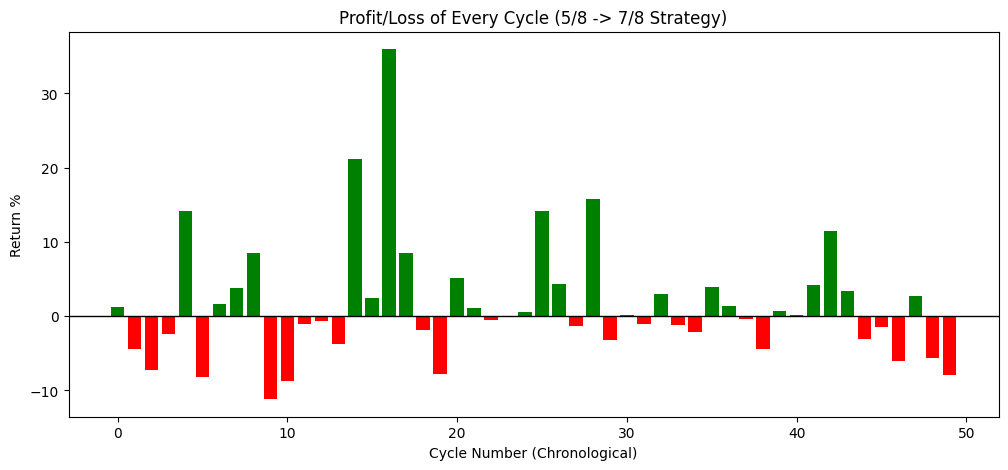

In [ ]:
# ==========================================
# 进阶分析：按年份检查策略稳定性
# ==========================================

# 1. 重新整理数据，带上年份标签
segment_stats = []

for i in range(len(full_idxs)):
    start = full_idxs[i]
    # 找下一个 Full 或数据结束
    next_full = full_idxs[i+1] if i < len(full_idxs)-1 else len(df)

    # 找 5/8 和 7/8
    current_58 = [x for x in marker_58_idxs if x > start and x < next_full]
    current_78 = [x for x in marker_78_idxs if x > start and x < next_full]

    if not current_58 or not current_78:
        continue

    idx_58 = current_58[0]
    idx_78 = current_78[0]

    # 获取关键价格
    price_full = df.iloc[start]['Open']
    price_58 = df.iloc[idx_58]['Open']
    price_78 = df.iloc[idx_78]['Open']

    # 获取年份
    cycle_year = df.iloc[start]['Date'].year

    # 计算核心策略收益：在 5/8 买入，在 7/8 卖出
    strategy_return = (price_78 - price_58) / price_58 * 100

    segment_stats.append({
        'Year': cycle_year,
        'Return': strategy_return
    })

# 2. 转换为 DataFrame 并按年份聚合
stats_df = pd.DataFrame(segment_stats)

print("\n=== 策略年度体检报告 (5/8 买入 -> 7/8 卖出) ===")
print("-" * 40)

# 按年份统计胜率和平均收益
yearly_agg = stats_df.groupby('Year')['Return'].agg(['count', 'mean', 'sum', lambda x: (x > 0).mean() * 100])
yearly_agg.columns = ['交易次数', '平均单次收益%', '年度总收益%', '胜率%']

print(yearly_agg)
print("-" * 40)

total_win_rate = (stats_df['Return'] > 0).mean() * 100
print(f"💰 4年总胜率: {total_win_rate:.2f}%")
print(f"💰 4年总计收益 (单利累加): {stats_df['Return'].sum():.2f}%")

# 3. 画个柱状图看看每一笔交易
plt.figure(figsize=(12, 5))
colors = ['green' if x > 0 else 'red' for x in stats_df['Return']]
plt.bar(range(len(stats_df)), stats_df['Return'], color=colors)
plt.title('Profit/Loss of Every Cycle (5/8 -> 7/8 Strategy)')
plt.xlabel('Cycle Number (Chronological)')
plt.ylabel('Return %')
plt.axhline(0, color='black', linewidth=1)
plt.show()

In [ ]:
# ==========================================
# 进阶分析：加入 MA200 趋势滤网
# ==========================================

# 1. 计算 MA200 指标
df['MA200'] = df['Close'].rolling(window=200).mean()

filtered_stats = []

for i in range(len(full_idxs)):
    start = full_idxs[i]
    next_full = full_idxs[i+1] if i < len(full_idxs)-1 else len(df)

    current_58 = [x for x in marker_58_idxs if x > start and x < next_full]
    current_78 = [x for x in marker_78_idxs if x > start and x < next_full]

    if not current_58 or not current_78:
        continue

    idx_58 = current_58[0]
    idx_78 = current_78[0]

    # === 关键过滤逻辑 ===
    # 获取 5/8 (买入点) 当时的收盘价 和 MA200
    price_buy = df.iloc[idx_58]['Open']
    ma_at_buy = df.iloc[idx_58]['MA200']
    price_sell = df.iloc[idx_78]['Open']

    # 只有当 价格 > MA200 时才开单
    if price_buy > ma_at_buy:
        trade_result = (price_sell - price_buy) / price_buy * 100
        action = "做多"
    else:
        # 如果价格在均线下方，我们可以选择：
        # 1. 空仓 (收益 0)
        # 2. 或者 做空 (反着来)
        # 这里我们假设 "避险模式" -> 空仓
        trade_result = 0
        action = "空仓"

    filtered_stats.append({
        'Year': df.iloc[start]['Date'].year,
        'Raw_Return': (price_sell - price_buy) / price_buy * 100, # 原始收益
        'Filtered_Return': trade_result, # 过滤后收益
        'Action': action
    })

# 2. 统计对比
filter_df = pd.DataFrame(filtered_stats)
comparison = filter_df.groupby('Year')[['Raw_Return', 'Filtered_Return']].sum()
comparison.columns = ['原始策略收益%', 'MA200过滤后收益%']

print("\n=== MA200 趋势滤网效果对比 ===")
print(comparison)

print("-" * 40)
print(f"原始 4年总收益: {filter_df['Raw_Return'].sum():.2f}%")
print(f"过滤后 4年总收益: {filter_df['Filtered_Return'].sum():.2f}%")

# 3. 看看 2022 年躲过了多少次亏损
avoided_losses = filter_df[(filter_df['Year'] == 2022) & (filter_df['Action'] == '空仓')]
print(f"\n2022年 (熊市) 成功避开了 {len(avoided_losses)} 次下跌交易。")


=== MA200 趋势滤网效果对比 ===
        原始策略收益%  MA200过滤后收益%
Year                        
2021  -3.113879     0.000000
2022 -15.083962    -4.245930
2023  83.229300    44.184183
2024  10.708654    10.907137
2025  -1.382206    -0.557256
----------------------------------------
原始 4年总收益: 74.36%
过滤后 4年总收益: 50.29%

2022年 (熊市) 成功避开了 7 次下跌交易。



=== 多空双开策略 (基于 MA200) ===
Year
2021     3.113879
2022     6.592101
2023     5.139065
2024    11.105621
2025     0.267695
Name: Return, dtype: float64
----------------------------------------
💰 4年总收益 (多空双开): 26.22%


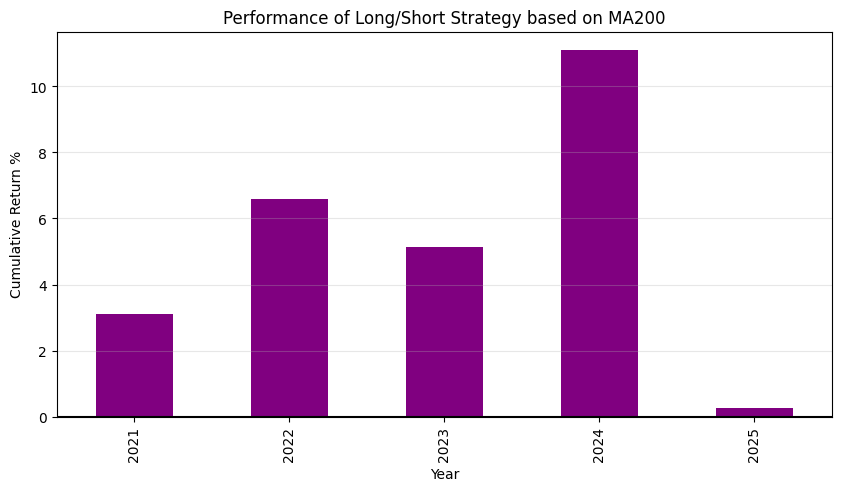

In [ ]:
# ==========================================
# 进阶策略：MA200 趋势跟随 (牛市做多/熊市做空)
# ==========================================

long_short_stats = []

for i in range(len(full_idxs)):
    start = full_idxs[i]
    next_full = full_idxs[i+1] if i < len(full_idxs)-1 else len(df)

    current_58 = [x for x in marker_58_idxs if x > start and x < next_full]
    current_78 = [x for x in marker_78_idxs if x > start and x < next_full]

    if not current_58 or not current_78:
        continue

    idx_58 = current_58[0]
    idx_78 = current_78[0]

    price_buy = df.iloc[idx_58]['Open']
    price_sell = df.iloc[idx_78]['Open']

    # 获取 5/8 时的 MA200
    ma_at_entry = df.iloc[idx_58]['MA200']

    # 策略逻辑
    if price_buy > ma_at_entry:
        # === 趋势向上：做多 ===
        # 收益 = (卖价 - 买价) / 买价
        trade_return = (price_sell - price_buy) / price_buy * 100
        direction = "做多 (Long)"
    else:
        # === 趋势向下：做空 ===
        # 收益 = (买价 - 卖价) / 买价  <-- 做空是跌了才赚钱
        trade_return = (price_buy - price_sell) / price_buy * 100
        direction = "做空 (Short)"

    long_short_stats.append({
        'Year': df.iloc[start]['Date'].year,
        'Return': trade_return,
        'Direction': direction
    })

# 转换与统计
ls_df = pd.DataFrame(long_short_stats)
ls_agg = ls_df.groupby('Year')['Return'].sum()

print("\n=== 多空双开策略 (基于 MA200) ===")
print(ls_agg)
print("-" * 40)
print(f"💰 4年总收益 (多空双开): {ls_df['Return'].sum():.2f}%")

# 可视化年度表现
ls_agg.plot(kind='bar', color='purple', figsize=(10, 5))
plt.title('Performance of Long/Short Strategy based on MA200')
plt.ylabel('Cumulative Return %')
plt.axhline(0, color='black')
plt.grid(axis='y', alpha=0.3)
plt.show()


=== 最终策略 (带0.5%缓冲区) ===
Year
2021     4.370426
2022    -7.610033
2023     5.139065
2024    11.105621
2025    -2.464431
Name: Return, dtype: float64
----------------------------------------
💰 4年总收益: 10.54%


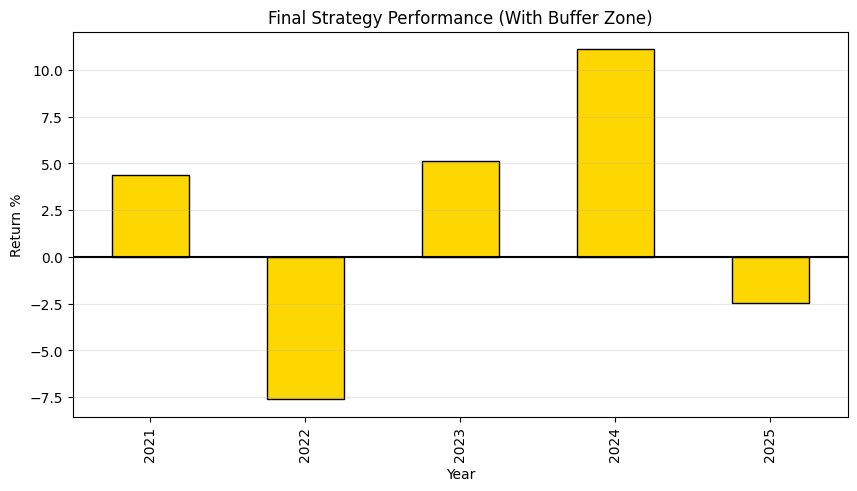

In [ ]:
# ==========================================
# 最终版策略：带缓冲区的趋势跟随 (避免震荡磨损)
# ==========================================

buffer_pct = 0.005 # 0.5% 的缓冲区，过滤假突破

final_stats = []

for i in range(len(full_idxs)):
    start = full_idxs[i]
    next_full = full_idxs[i+1] if i < len(full_idxs)-1 else len(df)

    current_58 = [x for x in marker_58_idxs if x > start and x < next_full]
    current_78 = [x for x in marker_78_idxs if x > start and x < next_full]

    if not current_58 or not current_78:
        continue

    idx_58 = current_58[0]
    idx_78 = current_78[0]

    price_buy = df.iloc[idx_58]['Open']
    ma_at_entry = df.iloc[idx_58]['MA200']
    price_sell = df.iloc[idx_78]['Open']

    # === 策略逻辑 (带缓冲区) ===

    # 1. 强多头趋势
    if price_buy > ma_at_entry * (1 + buffer_pct):
        trade_return = (price_sell - price_buy) / price_buy * 100
        action = "做多"

    # 2. 强空头趋势
    elif price_buy < ma_at_entry * (1 - buffer_pct):
        trade_return = (price_buy - price_sell) / price_buy * 100
        action = "做空"

    # 3. 震荡区 (在均线附近 0.5% 上下波动) -> 不做单
    else:
        trade_return = 0
        action = "观望"

    final_stats.append({
        'Year': df.iloc[start]['Date'].year,
        'Return': trade_return
    })

# 统计
final_df = pd.DataFrame(final_stats)
final_agg = final_df.groupby('Year')['Return'].sum()

print("\n=== 最终策略 (带0.5%缓冲区) ===")
print(final_agg)
print("-" * 40)
print(f"💰 4年总收益: {final_df['Return'].sum():.2f}%")

# 对比三种情况的图表
plt.figure(figsize=(10, 5))
final_agg.plot(kind='bar', color='gold', edgecolor='black')
plt.title('Final Strategy Performance (With Buffer Zone)')
plt.ylabel('Return %')
plt.axhline(0, color='black')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [ ]:
# ==========================================
# 终极测试：寻找最佳均线滤网 (参数扫描)
# ==========================================

# 我们要测试的均线周期列表
ma_windows = [24, 50, 100, 200]
results = {}

# 预先计算所有 MA
for w in ma_windows:
    df[f'MA_{w}'] = df['Close'].rolling(window=w).mean()

print(f"{'MA周期':<10} | {'总收益%':<10} | {'2022(熊)收益%':<15} | {'2023(牛)收益%':<15} | {'交易次数':<10}")
print("-" * 75)

for w in ma_windows:
    col_name = f'MA_{w}'
    stats = []

    for i in range(len(full_idxs)):
        start = full_idxs[i]
        next_full = full_idxs[i+1] if i < len(full_idxs)-1 else len(df)

        current_58 = [x for x in marker_58_idxs if x > start and x < next_full]
        current_78 = [x for x in marker_78_idxs if x > start and x < next_full]

        if not current_58 or not current_78:
            continue

        idx_58 = current_58[0]
        idx_78 = current_78[0]

        price_buy = df.iloc[idx_58]['Open']
        ma_val = df.iloc[idx_58][col_name]
        price_sell = df.iloc[idx_78]['Open']

        cycle_year = df.iloc[start]['Date'].year

        # === 策略逻辑：只做多 (Long Only) ===
        # 滤网：只有价格在均线之上才做多，否则空仓
        if price_buy > ma_val:
            ret = (price_sell - price_buy) / price_buy * 100
        else:
            ret = 0 # 空仓避险

        stats.append({'Year': cycle_year, 'Return': ret})

    # 统计该 MA 下的表现
    res_df = pd.DataFrame(stats)
    total_ret = res_df['Return'].sum()

    # 提取特定年份表现
    ret_2022 = res_df[res_df['Year'] == 2022]['Return'].sum()
    ret_2023 = res_df[res_df['Year'] == 2023]['Return'].sum()
    trade_count = len(res_df[res_df['Return'] != 0])

    print(f"MA {w:<7} | {total_ret:<12.2f} | {ret_2022:<17.2f} | {ret_2023:<17.2f} | {trade_count:<10}")

print("-" * 75)
print("基准 (无滤网) | 74.36        | -15.08            | 83.23             | 50")

MA周期       | 总收益%       | 2022(熊)收益%      | 2023(牛)收益%      | 交易次数      
---------------------------------------------------------------------------
MA 24      | 76.63        | -11.64            | 68.00             | 25        
MA 50      | 25.17        | -9.24             | 27.71             | 22        
MA 100     | 38.26        | -4.47             | 30.50             | 25        
MA 200     | 50.29        | -4.25             | 44.18             | 26        
---------------------------------------------------------------------------
基准 (无滤网) | 74.36        | -15.08            | 83.23             | 50


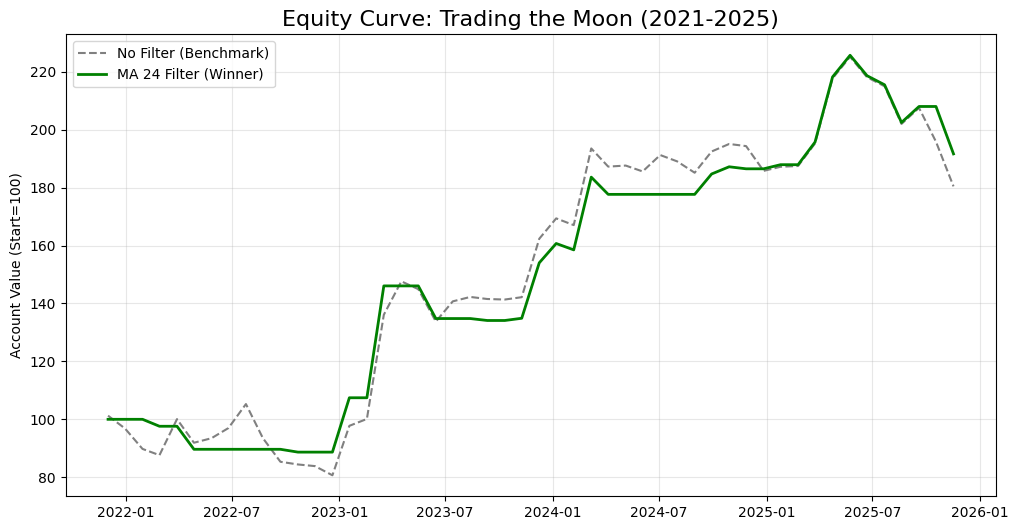

最终资金对比:
无滤网: 180.43
MA 24 : 191.64


In [ ]:
# ==========================================
# 最终决战：基准策略 vs MA24 增强版
# ==========================================

equity_benchmark = [100] # 初始资金 100
equity_ma24 = [100]

dates = []

for i in range(len(full_idxs)):
    start = full_idxs[i]
    next_full = full_idxs[i+1] if i < len(full_idxs)-1 else len(df)

    current_58 = [x for x in marker_58_idxs if x > start and x < next_full]
    current_78 = [x for x in marker_78_idxs if x > start and x < next_full]

    if not current_58 or not current_78:
        continue

    idx_58 = current_58[0]
    idx_78 = current_78[0]

    price_buy = df.iloc[idx_58]['Open']
    price_sell = df.iloc[idx_78]['Open']
    ma24_val = df.iloc[idx_58]['MA_24']

    trade_date = df.iloc[idx_78]['Date']
    dates.append(trade_date)

    # 1. 基准策略收益 (无脑买)
    ret_bench = (price_sell - price_buy) / price_buy
    # 更新资金曲线 (复利计算)
    equity_benchmark.append(equity_benchmark[-1] * (1 + ret_bench))

    # 2. MA24 策略收益 (有条件买)
    if price_buy > ma24_val:
        ret_ma24 = (price_sell - price_buy) / price_buy
    else:
        ret_ma24 = 0 # 空仓

    equity_ma24.append(equity_ma24[-1] * (1 + ret_ma24))

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(dates, equity_benchmark[1:], label='No Filter (Benchmark)', color='gray', linestyle='--')
plt.plot(dates, equity_ma24[1:], label='MA 24 Filter (Winner)', color='green', linewidth=2)

plt.title('Equity Curve: Trading the Moon (2021-2025)', fontsize=16)
plt.ylabel('Account Value (Start=100)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"最终资金对比:")
print(f"无滤网: {equity_benchmark[-1]:.2f}")
print(f"MA 24 : {equity_ma24[-1]:.2f}")